## Flight Delay Analysis

## Introduction
### Objective is to create a model that can classifier whether a flight will likely be delayed or not.
##### Notes: I created this analysis initially in Databricks.¶
##### Data source came from:
##### 1. https://www.transtats.bts.gov/DL_SelectFields.aspx?gnoyr_VQ=FGK&QO_fu146_anzr=b0-gvzr
##### 2. https://ourairports.com/data/

In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ | done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317146 sha256=67dcd8f90e8a6ac829d09d3808a35f3dfb796196e3e05d65b2f6251f026cec9b
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark
Note: you may need to restart the kernel to use updated packages.


In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import DoubleType, IntegerType, StringType

In [4]:
spark = SparkSession.builder \
                    .appName("FlightDelayAnalysis") \
                    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/11 03:35:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Reading and Preprocessing Data

In [5]:
df_airports = spark.read.options(header="true").csv("/kaggle/input/flightdelay-data/airports.csv")
df_flights = spark.read.options(header="true").csv("/kaggle/input/flightdelay-data/flights.csv")
df_airlines = spark.read.options(header="true").csv("/kaggle/input/flightdelay-data/airlines.csv")

In [6]:
df_flights.printSchema()

root
 |-- DAY_OF_WEEK: string (nullable = true)
 |-- OP_UNIQUE_CARRIER: string (nullable = true)
 |-- ORIGIN_AIRPORT_ID: string (nullable = true)
 |-- ORIGIN_AIRPORT_SEQ_ID: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_CITY_NAME: string (nullable = true)
 |-- ORIGIN_STATE_ABR: string (nullable = true)
 |-- ORIGIN_STATE_NM: string (nullable = true)
 |-- DEST_AIRPORT_ID: string (nullable = true)
 |-- DEST_AIRPORT_SEQ_ID: string (nullable = true)
 |-- DEST_CITY_MARKET_ID: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEST_CITY_NAME: string (nullable = true)
 |-- DEST_STATE_ABR: string (nullable = true)
 |-- DEST_STATE_NM: string (nullable = true)
 |-- DEP_TIME: string (nullable = true)
 |-- DEP_DELAY: string (nullable = true)
 |-- ARR_TIME: string (nullable = true)
 |-- ARR_DELAY: string (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: string (nullable = true)
 |-- DISTANCE: string (nullable = true)



In [7]:
df_flights = df_flights.join(df_airlines, df_flights.OP_UNIQUE_CARRIER==df_airlines.Code)

In [8]:
df_flights = df_flights.drop(df_flights.Code)

In [9]:
display(df_airports.where(col("local_code") == "LAX").select("*"))

DataFrame[id: string, ident: string, type: string, name: string, latitude_deg: string, longitude_deg: string, elevation_ft: string, continent: string, iso_country: string, iso_region: string, municipality: string, scheduled_service: string, gps_code: string, iata_code: string, local_code: string, home_link: string, wikipedia_link: string, keywords: string]

In [10]:
df_airports1 = df_airports.drop('continent').drop('iso_country').drop('iso_region').drop('gps_code').drop('iata_code').drop('home_link').drop('wikipedia_link').drop('keywords').drop('scheduled_service').drop('ident').drop('id')

In [11]:
df_joined_dep=df_flights.join(df_airports1, df_flights.ORIGIN==df_airports1.local_code, "inner").withColumnRenamed('type','dep_type').withColumnRenamed('latitude_deg','dep_lat').withColumnRenamed('longitude_deg','dep_lon').withColumnRenamed('elevation_ft','dep_elevation_ft').withColumnRenamed('municipality','dep_municipality').withColumnRenamed('local_code','dep_local_code').withColumnRenamed('name','dep_name')

In [12]:
df_all_joined_dep_arr = df_joined_dep.join(df_airports1, df_joined_dep.DEST==df_airports1.local_code, "inner").withColumnRenamed('type','arr_type').withColumnRenamed('latitude_deg','arr_lat').withColumnRenamed('longitude_deg','arr_lon').withColumnRenamed('elevation_ft','arr_elevation_ft').withColumnRenamed('municipality','arr_municipality').withColumnRenamed('local_code','arr_local_code').withColumnRenamed('name','arr_name')

In [13]:
df_all_joined_dep_arr = df_all_joined_dep_arr.dropna("any")

In [14]:
df_all = df_all_joined_dep_arr.withColumn("dep_lat",df_all_joined_dep_arr.dep_lat.cast(DoubleType())).withColumn("dep_lon",df_all_joined_dep_arr.dep_lon.cast(DoubleType())).withColumn("arr_lat",df_all_joined_dep_arr.arr_lat.cast(DoubleType())).withColumn("arr_lon",df_all_joined_dep_arr.arr_lon.cast(DoubleType())).withColumn("DISTANCE",df_all_joined_dep_arr.DISTANCE.cast(IntegerType())).withColumn("DAY_OF_WEEK",df_all_joined_dep_arr.DAY_OF_WEEK.cast(IntegerType())).withColumn("ORIGIN_AIRPORT_ID",df_all_joined_dep_arr.ORIGIN_AIRPORT_ID.cast(IntegerType())).withColumn("ORIGIN_AIRPORT_SEQ_ID",df_all_joined_dep_arr.ORIGIN_AIRPORT_SEQ_ID.cast(IntegerType())).withColumn("DEST_AIRPORT_ID",df_all_joined_dep_arr.DEST_AIRPORT_ID.cast(IntegerType())).withColumn("DEST_AIRPORT_SEQ_ID",df_all_joined_dep_arr.DEST_AIRPORT_SEQ_ID.cast(IntegerType())).withColumn("DEP_TIME_int",df_all_joined_dep_arr.DEP_TIME.cast(IntegerType())).withColumn("DEP_DELAY",df_all_joined_dep_arr.DEP_DELAY.cast(IntegerType())).withColumn("ARR_DELAY",df_all_joined_dep_arr.ARR_DELAY.cast(IntegerType())).withColumn("ARR_TIME_int",df_all_joined_dep_arr.ARR_TIME.cast(IntegerType())).withColumn("ACTUAL_ELAPSED_TIME",df_all_joined_dep_arr.ACTUAL_ELAPSED_TIME.cast(IntegerType())).withColumn("dep_elevation_ft",df_all_joined_dep_arr.dep_elevation_ft.cast(IntegerType())).withColumn("arr_elevation_ft",df_all_joined_dep_arr.arr_elevation_ft.cast(IntegerType()))

In [15]:
df_all_add_2_cols = df_all.withColumn("dep_delay_int", when(col("DEP_DELAY") <= 0, 0).when(col("DEP_DELAY") > 1, 1)).withColumn("arr_delay_int", when(col("ARR_DELAY") <= 0, 0).when(col("ARR_DELAY") > 1, 1)).dropna()

In [16]:
df_all_add_2_cols.printSchema()

root
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- OP_UNIQUE_CARRIER: string (nullable = true)
 |-- ORIGIN_AIRPORT_ID: integer (nullable = true)
 |-- ORIGIN_AIRPORT_SEQ_ID: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_CITY_NAME: string (nullable = true)
 |-- ORIGIN_STATE_ABR: string (nullable = true)
 |-- ORIGIN_STATE_NM: string (nullable = true)
 |-- DEST_AIRPORT_ID: integer (nullable = true)
 |-- DEST_AIRPORT_SEQ_ID: integer (nullable = true)
 |-- DEST_CITY_MARKET_ID: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEST_CITY_NAME: string (nullable = true)
 |-- DEST_STATE_ABR: string (nullable = true)
 |-- DEST_STATE_NM: string (nullable = true)
 |-- DEP_TIME: string (nullable = true)
 |-- DEP_DELAY: integer (nullable = true)
 |-- ARR_TIME: string (nullable = true)
 |-- ARR_DELAY: integer (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: integer (nullable = true)
 |-- DISTANCE: integer (nullable = true)
 |-- Description: string (nullable =

In [17]:
df_all_1 = df_all_add_2_cols.drop("DEP_DELAY").drop("ARR_DELAY")

In [18]:
display(df_all_1)

DataFrame[DAY_OF_WEEK: int, OP_UNIQUE_CARRIER: string, ORIGIN_AIRPORT_ID: int, ORIGIN_AIRPORT_SEQ_ID: int, ORIGIN: string, ORIGIN_CITY_NAME: string, ORIGIN_STATE_ABR: string, ORIGIN_STATE_NM: string, DEST_AIRPORT_ID: int, DEST_AIRPORT_SEQ_ID: int, DEST_CITY_MARKET_ID: string, DEST: string, DEST_CITY_NAME: string, DEST_STATE_ABR: string, DEST_STATE_NM: string, DEP_TIME: string, ARR_TIME: string, ACTUAL_ELAPSED_TIME: int, DISTANCE: int, Description: string, dep_type: string, dep_name: string, dep_lat: double, dep_lon: double, dep_elevation_ft: int, dep_municipality: string, dep_local_code: string, arr_type: string, arr_name: string, arr_lat: double, arr_lon: double, arr_elevation_ft: int, arr_municipality: string, arr_local_code: string, DEP_TIME_int: int, ARR_TIME_int: int, dep_delay_int: int, arr_delay_int: int]

## Machine Learning - StringIndexer

In [19]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, VectorIndexer, MinMaxScaler, OneHotEncoder, MaxAbsScaler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier 
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from xgboost.spark import SparkXGBClassifier

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [20]:
indexers = [StringIndexer(inputCol="OP_UNIQUE_CARRIER", outputCol="_OHE_OP_UNIQUE_CARRIER") , StringIndexer(inputCol="DEST", outputCol="_OHE_OP_DEST") , StringIndexer(inputCol="ORIGIN", outputCol="_OHE_OP_ORIGIN") , StringIndexer(inputCol="ORIGIN_CITY_NAME", outputCol="_OHE_ORIGIN_CITY_NAME") , StringIndexer(inputCol="DEST_CITY_NAME", outputCol="_OHE_DEST_CITY_NAME") , StringIndexer(inputCol="DEST_STATE_ABR", outputCol="_OHE_DEST_STATE_ABR") , StringIndexer(inputCol="Description", outputCol="_OHE_description") , StringIndexer(inputCol="dep_type", outputCol="_OHE_dep_type") , StringIndexer(inputCol="dep_name", outputCol="_OHE_dep_name") , StringIndexer(inputCol="arr_type", outputCol="_OHE_arr_type") , StringIndexer(inputCol="arr_name", outputCol="_OHE_arr_name")]

In [21]:
pipeline_of_stringindexers = Pipeline(stages=indexers)
model0 = pipeline_of_stringindexers.fit(df_all_1).transform(df_all_1)

23/05/11 03:36:13 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [22]:
model0.printSchema()

root
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- OP_UNIQUE_CARRIER: string (nullable = true)
 |-- ORIGIN_AIRPORT_ID: integer (nullable = true)
 |-- ORIGIN_AIRPORT_SEQ_ID: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_CITY_NAME: string (nullable = true)
 |-- ORIGIN_STATE_ABR: string (nullable = true)
 |-- ORIGIN_STATE_NM: string (nullable = true)
 |-- DEST_AIRPORT_ID: integer (nullable = true)
 |-- DEST_AIRPORT_SEQ_ID: integer (nullable = true)
 |-- DEST_CITY_MARKET_ID: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEST_CITY_NAME: string (nullable = true)
 |-- DEST_STATE_ABR: string (nullable = true)
 |-- DEST_STATE_NM: string (nullable = true)
 |-- DEP_TIME: string (nullable = true)
 |-- ARR_TIME: string (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: integer (nullable = true)
 |-- DISTANCE: integer (nullable = true)
 |-- Description: string (nullable = true)
 |-- dep_type: string (nullable = true)
 |-- dep_name: string (nullable = tru

In [23]:
display(model0)

DataFrame[DAY_OF_WEEK: int, OP_UNIQUE_CARRIER: string, ORIGIN_AIRPORT_ID: int, ORIGIN_AIRPORT_SEQ_ID: int, ORIGIN: string, ORIGIN_CITY_NAME: string, ORIGIN_STATE_ABR: string, ORIGIN_STATE_NM: string, DEST_AIRPORT_ID: int, DEST_AIRPORT_SEQ_ID: int, DEST_CITY_MARKET_ID: string, DEST: string, DEST_CITY_NAME: string, DEST_STATE_ABR: string, DEST_STATE_NM: string, DEP_TIME: string, ARR_TIME: string, ACTUAL_ELAPSED_TIME: int, DISTANCE: int, Description: string, dep_type: string, dep_name: string, dep_lat: double, dep_lon: double, dep_elevation_ft: int, dep_municipality: string, dep_local_code: string, arr_type: string, arr_name: string, arr_lat: double, arr_lon: double, arr_elevation_ft: int, arr_municipality: string, arr_local_code: string, DEP_TIME_int: int, ARR_TIME_int: int, dep_delay_int: int, arr_delay_int: int, _OHE_OP_UNIQUE_CARRIER: double, _OHE_OP_DEST: double, _OHE_OP_ORIGIN: double, _OHE_ORIGIN_CITY_NAME: double, _OHE_DEST_CITY_NAME: double, _OHE_DEST_STATE_ABR: double, _OHE_desc

In [24]:
model1 = model0.drop('OP_UNIQUE_CARRIER').drop('ORIGIN').drop('ORIGIN_STATE_NM').drop('DEST_CITY_MARKET_ID').drop('ORIGIN_STATE_ABR').drop('dep_municipality').drop('ORIGIN_CITY_NAME').drop('ORIGIN_AIRPORT_SEQ_ID').drop('DEST_AIRPORT_SEQ_ID').drop('DEST_STATE_NM').drop('DEST_STATE_NM').drop('DEP_TIME').drop('ARR_TIME').drop('arr_municipality').drop('DEST').drop('DEST_CITY_NAME').drop('DEST_STATE_ABRDEST_CITY_NAME').drop('Description').drop('DEST_STATE_ABR').drop('dep_type').drop('dep_name').drop('arr_type').drop('arr_name').drop('dep_local_code').drop('arr_local_code')

In [25]:
model1.printSchema()

root
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- ORIGIN_AIRPORT_ID: integer (nullable = true)
 |-- DEST_AIRPORT_ID: integer (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: integer (nullable = true)
 |-- DISTANCE: integer (nullable = true)
 |-- dep_lat: double (nullable = true)
 |-- dep_lon: double (nullable = true)
 |-- dep_elevation_ft: integer (nullable = true)
 |-- arr_lat: double (nullable = true)
 |-- arr_lon: double (nullable = true)
 |-- arr_elevation_ft: integer (nullable = true)
 |-- DEP_TIME_int: integer (nullable = true)
 |-- ARR_TIME_int: integer (nullable = true)
 |-- dep_delay_int: integer (nullable = true)
 |-- arr_delay_int: integer (nullable = true)
 |-- _OHE_OP_UNIQUE_CARRIER: double (nullable = false)
 |-- _OHE_OP_DEST: double (nullable = false)
 |-- _OHE_OP_ORIGIN: double (nullable = false)
 |-- _OHE_ORIGIN_CITY_NAME: double (nullable = false)
 |-- _OHE_DEST_CITY_NAME: double (nullable = false)
 |-- _OHE_DEST_STATE_ABR: double (nullable = false)
 |-- _OHE_descripti

In [26]:
display(model1)

DataFrame[DAY_OF_WEEK: int, ORIGIN_AIRPORT_ID: int, DEST_AIRPORT_ID: int, ACTUAL_ELAPSED_TIME: int, DISTANCE: int, dep_lat: double, dep_lon: double, dep_elevation_ft: int, arr_lat: double, arr_lon: double, arr_elevation_ft: int, DEP_TIME_int: int, ARR_TIME_int: int, dep_delay_int: int, arr_delay_int: int, _OHE_OP_UNIQUE_CARRIER: double, _OHE_OP_DEST: double, _OHE_OP_ORIGIN: double, _OHE_ORIGIN_CITY_NAME: double, _OHE_DEST_CITY_NAME: double, _OHE_DEST_STATE_ABR: double, _OHE_description: double, _OHE_dep_type: double, _OHE_dep_name: double, _OHE_arr_type: double, _OHE_arr_name: double]

## Heatmap

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot: >

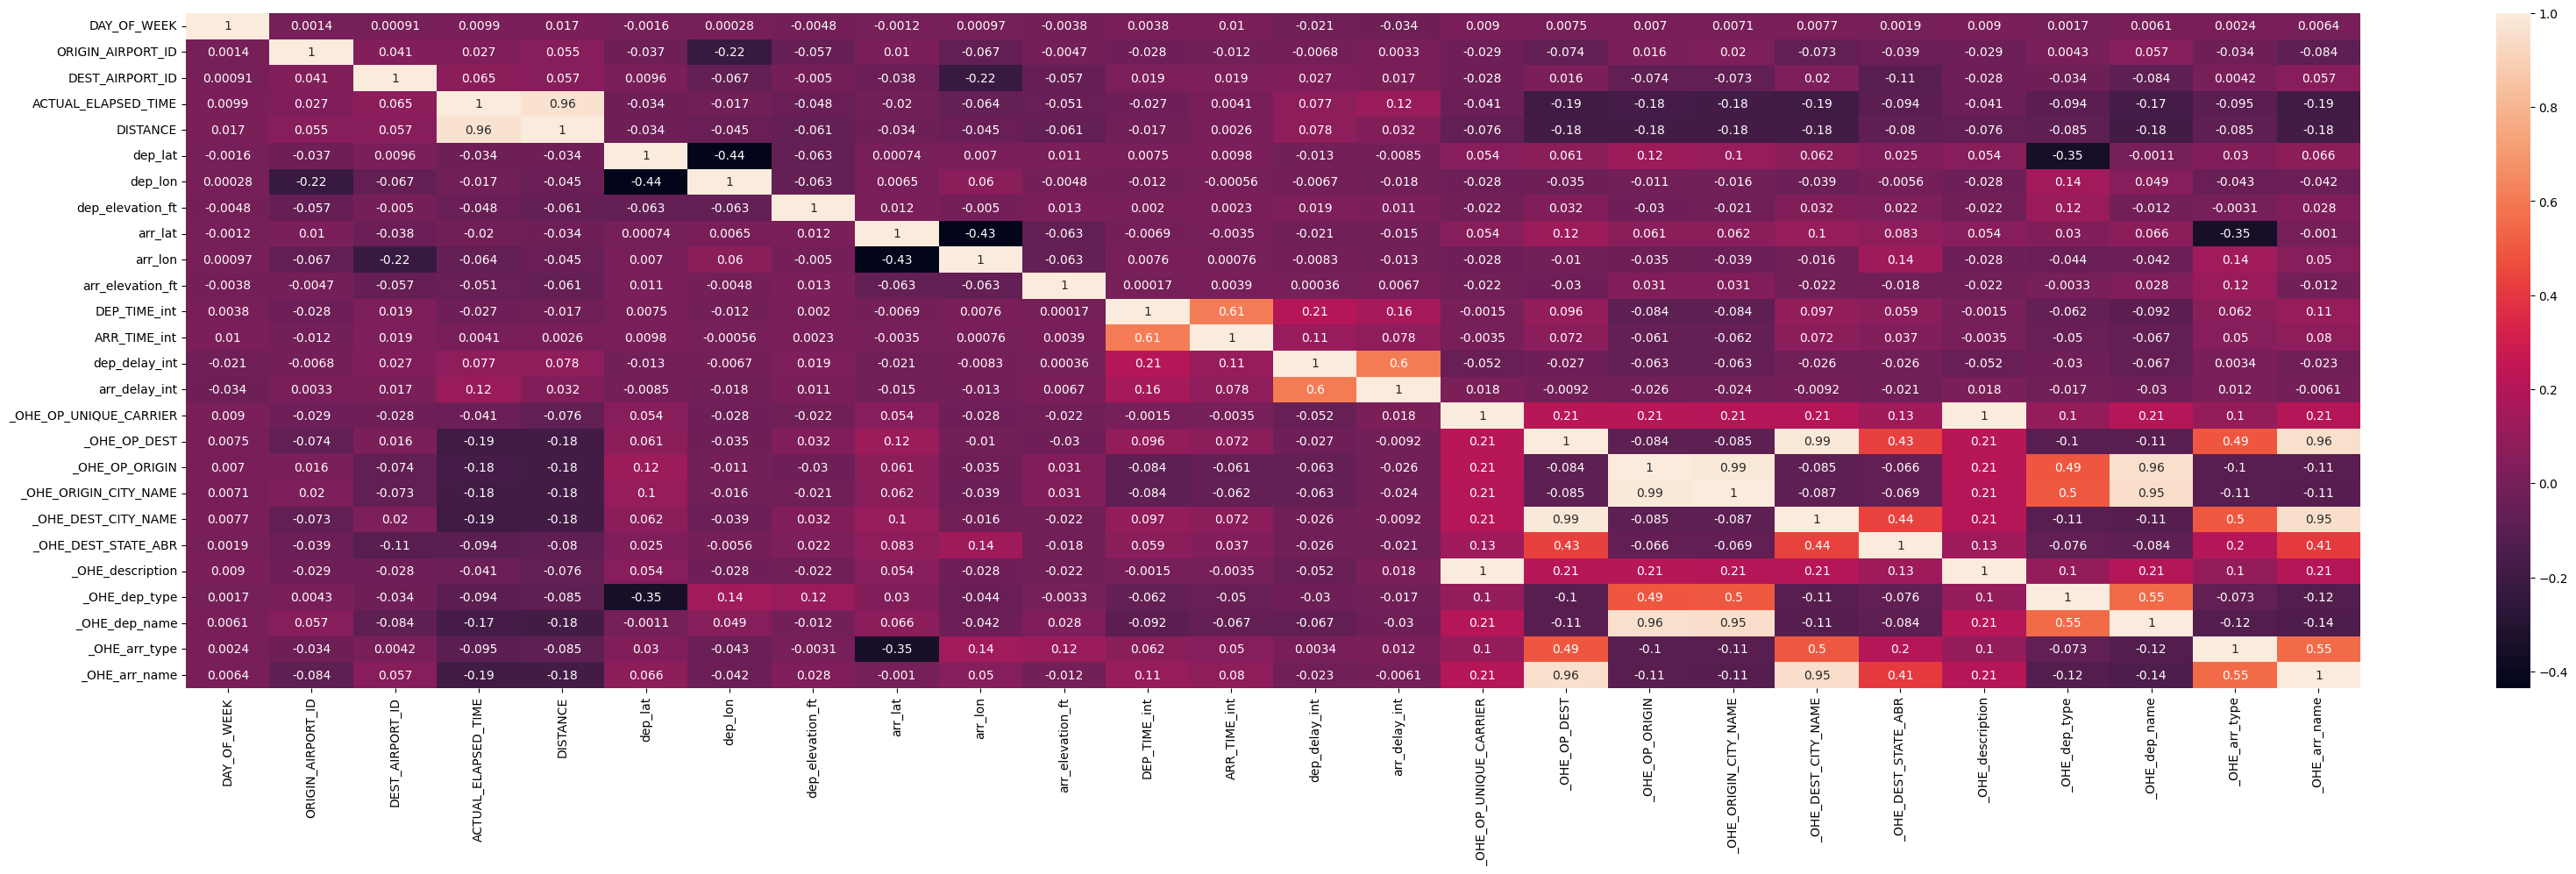

In [28]:
model1_pd = model1.toPandas()
fig, ax = plt.subplots(figsize=(40, 10))
sns.heatmap(model1_pd.corr(), annot=True)

In [29]:
feature_columns = ['DAY_OF_WEEK','ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'DISTANCE', 'dep_lat', 'dep_lon', 'dep_elevation_ft', 'arr_lat', 'arr_lon', 'arr_elevation_ft', '_OHE_OP_UNIQUE_CARRIER', '_OHE_OP_DEST', '_OHE_OP_ORIGIN', '_OHE_ORIGIN_CITY_NAME', '_OHE_DEST_CITY_NAME', '_OHE_DEST_STATE_ABR', '_OHE_description', '_OHE_dep_type', '_OHE_dep_name', '_OHE_arr_type', '_OHE_arr_name']

In [30]:
#op1: without using pipeline
#VectorAssembler: to add all the features into a single column
#assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
#model2 = assembler.transform(model1)

#op2: using pipeline but MinMaxScaler not really working
#vectAssembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
#minMax = MinMaxScaler(inputCol="features", outputCol="normFeatures")
#pipeline = Pipeline(stages=[vectAssembler, minMax])
#model2 = pipeline.fit(model1).transform(model1)

#op3: using pipeline but MinMaxScaler not really working
vectAssembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
minMax = MinMaxScaler(inputCol="features", outputCol="normfeatures")
pipeline = Pipeline(stages=[vectAssembler, minMax])
model1_1 = pipeline.fit(model1).transform(model1)

In [31]:
finalized_data = model1_1.select('normfeatures', 'dep_delay_int')
display(finalized_data)

DataFrame[normfeatures: vector, dep_delay_int: int]

In [32]:
#split data into train and test
train_data, test_data = finalized_data.randomSplit([0.8, 0.2], seed=42)

## 1st Set: ML Algorithms - MinMaxScaler

## 1st Set: Logistic Regression

In [33]:
#create LogisticRegression model then fit it to training data
train_data_lr = train_data
test_data_lr = test_data
lr = LogisticRegression(labelCol="dep_delay_int", featuresCol="normfeatures")
lr_model = lr.fit(train_data_lr)

23/05/11 03:38:16 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


## 1st Set: Decision Tree Classifier

In [34]:
#create DecisionTreeClassifier model then fit it to training data
train_data_dtc = train_data
test_data_dtc = test_data
dtc = DecisionTreeClassifier(labelCol="dep_delay_int", featuresCol="normfeatures")
dtc_model = dtc.fit(train_data_dtc)

## 1st Set: XGBoost

In [35]:
#create XGBoost model then fit it to training data
train_data_xgb = train_data
test_data_xgb = test_data
xgb = SparkXGBClassifier(features_col="normfeatures", label_col="dep_delay_int", num_workers=2)
xgb_model = xgb.fit(train_data_xgb)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[03:39:51] task 0 got new rank 0
[03:39:51] task 1 got new rank 1
/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:782: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn("Loading a native XGBoost model with Scikit-Learn interface.")


In [36]:
# Evaluations

In [37]:
#Eval-Logistric Regression

In [38]:
predictions_df_lr = lr_model.transform(train_data_lr)

In [39]:
predictions_df_lr = predictions_df_lr.withColumnRenamed("prediction", "prediction_lr").withColumnRenamed("dep_delay_int", "dep_delay_int_lr").withColumnRenamed("rawPrediction", "rawPrediction_lr").withColumnRenamed("probability", "probability_lr")
predictions_df_lr.select("rawPrediction_lr", "probability_lr", "prediction_lr", "dep_delay_int_lr").show(100)

+--------------------+--------------------+-------------+----------------+
|    rawPrediction_lr|      probability_lr|prediction_lr|dep_delay_int_lr|
+--------------------+--------------------+-------------+----------------+
|[0.78508514244465...|[0.68677504235925...|          0.0|               0|
|[0.78508514244465...|[0.68677504235925...|          0.0|               0|
|[0.78508514244465...|[0.68677504235925...|          0.0|               0|
|[0.78508514244465...|[0.68677504235925...|          0.0|               0|
|[0.78508514244465...|[0.68677504235925...|          0.0|               0|
|[0.78508514244465...|[0.68677504235925...|          0.0|               0|
|[0.78508514244465...|[0.68677504235925...|          0.0|               1|
|[0.78508514244465...|[0.68677504235925...|          0.0|               1|
|[0.78508514244465...|[0.68677504235925...|          0.0|               1|
|[0.86130953937971...|[0.70293418202030...|          0.0|               0|
|[0.98703973756108...|[0.

In [40]:
#ok in DataBricks but timed out in Kaggle
#tp_lr = float(predictions_df_lr.filter("prediction_lr == 1.0 AND dep_delay_int_lr == 1").count())
#fp_lr = float(predictions_df_lr.filter("prediction_lr == 1.0 AND dep_delay_int_lr == 0").count())
#tn_lr = float(predictions_df_lr.filter("prediction_lr == 0.0 AND dep_delay_int_lr == 0").count())
#fn_lr = float(predictions_df_lr.filter("prediction_lr == 0.0 AND dep_delay_int_lr == 1").count())
#pr_lr = tp_lr / (tp_lr + fp_lr)
#re_lr = tp_lr / (tp_lr + fn_lr)
#metrics = spark.createDataFrame([
# ("TP", tp_lr),
# ("FP", fp_lr),
# ("TN", tn_lr),
# ("FN", fn_lr),
# ("Precision", pr_lr),
# ("Recall", re_lr),
# ("myAccuracy", (tp_lr+tn_lr)/(tp_lr+fp_lr+tn_lr+fn_lr)),
# ("F1", 2*pr_lr*re_lr/(re_lr+pr_lr))],["metric_for_lr1", "value"])
#metrics.show()

In [41]:
evaluator_lr_mc_acc = MulticlassClassificationEvaluator(labelCol="dep_delay_int_lr", predictionCol="prediction_lr", metricName="accuracy")
lr_accuracy = evaluator_lr_mc_acc.evaluate(predictions_df_lr)

In [42]:
evaluator_lr_mc_precision = MulticlassClassificationEvaluator(labelCol="dep_delay_int_lr", predictionCol="prediction_lr", metricName="precisionByLabel")
lr_precision = evaluator_lr_mc_precision.evaluate(predictions_df_lr)

In [43]:
evaluator_lr_mc_recall = MulticlassClassificationEvaluator(labelCol="dep_delay_int_lr", predictionCol="prediction_lr", metricName="recallByLabel")
lr_recall = evaluator_lr_mc_recall.evaluate(predictions_df_lr)

In [44]:
evaluator_lr_mc_f1 = MulticlassClassificationEvaluator(labelCol="dep_delay_int_lr", predictionCol="prediction_lr", metricName="f1")
lr_f1 = evaluator_lr_mc_f1.evaluate(predictions_df_lr)

In [45]:
#area under ROC
evaluator_lr_bc = BinaryClassificationEvaluator(labelCol="dep_delay_int_lr", rawPredictionCol="prediction_lr", metricName="areaUnderROC")
lr_areaUnderROC = evaluator_lr_bc.evaluate(predictions_df_lr)

In [46]:
#Eval-Decision Tree Classifier

In [47]:
predictions_df_dtc = dtc_model.transform(train_data_dtc)

In [48]:
predictions_df_dtc = predictions_df_dtc.withColumnRenamed("prediction", "prediction_dtc").withColumnRenamed("dep_delay_int", "dep_delay_int_dtc").withColumnRenamed("rawPrediction", "rawPrediction_dtc").withColumnRenamed("probability", "probability_dtc")
predictions_df_dtc.select("rawPrediction_dtc", "probability_dtc", "prediction_dtc", "dep_delay_int_dtc").show(100)

+-------------------+--------------------+--------------+-----------------+
|  rawPrediction_dtc|     probability_dtc|prediction_dtc|dep_delay_int_dtc|
+-------------------+--------------------+--------------+-----------------+
|[276905.0,123970.0]|[0.69075148113501...|           0.0|                0|
|[276905.0,123970.0]|[0.69075148113501...|           0.0|                0|
|[276905.0,123970.0]|[0.69075148113501...|           0.0|                0|
|[276905.0,123970.0]|[0.69075148113501...|           0.0|                0|
|[276905.0,123970.0]|[0.69075148113501...|           0.0|                0|
|[276905.0,123970.0]|[0.69075148113501...|           0.0|                0|
|[276905.0,123970.0]|[0.69075148113501...|           0.0|                1|
|[276905.0,123970.0]|[0.69075148113501...|           0.0|                1|
|[276905.0,123970.0]|[0.69075148113501...|           0.0|                1|
|[276905.0,123970.0]|[0.69075148113501...|           0.0|                0|
|[276905.0,1

In [49]:
#ok in DataBricks but timed out in Kaggle
#tp_dtc = float(predictions_df_dtc.filter("prediction_dtc == 1.0 AND dep_delay_int_dtc == 1").count())
#fp_dtc = float(predictions_df_dtc.filter("prediction_dtc == 1.0 AND dep_delay_int_dtc == 0").count())
#tn_dtc = float(predictions_df_dtc.filter("prediction_dtc == 0.0 AND dep_delay_int_dtc == 0").count())
#fn_dtc = float(predictions_df_dtc.filter("prediction_dtc == 0.0 AND dep_delay_int_dtc == 1").count())
#pr_dtc = tp_dtc / (tp_dtc + fp_dtc)
#re_dtc = tp_dtc / (tp_dtc + fn_dtc)
#metrics = spark.createDataFrame([
# ("TP", tp_dtc),
# ("FP", fp_dtc),
# ("TN", tn_dtc),
# ("FN", fn_dtc),
# ("Precision", pr_dtc),
# ("Recall", re_dtc),
# ("myAccuracy", (tp_dtc+tn_dtc)/(tp_dtc+fp_dtc+tn_dtc+fn_dtc)),
# ("F1", 2*pr_dtc*re_dtc/(re_dtc+pr_dtc))],["metric_for_dtc1", "value"])
#metrics.show()

In [50]:
evaluator_dtc_mc_acc = MulticlassClassificationEvaluator(labelCol="dep_delay_int_dtc", predictionCol="prediction_dtc", metricName="accuracy")
dtc_accuracy = evaluator_dtc_mc_acc.evaluate(predictions_df_dtc)

In [51]:
evaluator_dtc_mc_precision = MulticlassClassificationEvaluator(labelCol="dep_delay_int_dtc", predictionCol="prediction_dtc", metricName="precisionByLabel")
dtc_precision = evaluator_dtc_mc_precision.evaluate(predictions_df_dtc)

In [52]:
evaluator_dtc_mc_recall = MulticlassClassificationEvaluator(labelCol="dep_delay_int_dtc", predictionCol="prediction_dtc", metricName="recallByLabel")
dtc_recall = evaluator_dtc_mc_recall.evaluate(predictions_df_dtc)

In [53]:
evaluator_dtc_mc_f1 = MulticlassClassificationEvaluator(labelCol="dep_delay_int_dtc", predictionCol="prediction_dtc", metricName="f1")
dtc_f1 = evaluator_dtc_mc_f1.evaluate(predictions_df_dtc)

In [54]:
#area under ROC
evaluator_dtc_bc = BinaryClassificationEvaluator(labelCol="dep_delay_int_dtc", rawPredictionCol="prediction_dtc", metricName="areaUnderROC")
dtc_areaUnderROC = evaluator_dtc_bc.evaluate(predictions_df_dtc)

In [55]:
#Eval-XGBoost Classifier

In [56]:
predictions_df_xgb = xgb_model.transform(train_data_xgb)

In [57]:
predictions_df_xgb = predictions_df_xgb.withColumnRenamed("prediction", "prediction_xgb").withColumnRenamed("dep_delay_int", "dep_delay_int_xgb").withColumnRenamed("rawPrediction", "rawPrediction_xgb").withColumnRenamed("probability", "probability_xgb")
predictions_df_xgb.select("rawPrediction_xgb", "probability_xgb", "prediction_xgb", "dep_delay_int_xgb").show(100)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


+--------------------+--------------------+--------------+-----------------+
|   rawPrediction_xgb|     probability_xgb|prediction_xgb|dep_delay_int_xgb|
+--------------------+--------------------+--------------+-----------------+
|[0.86511373519897...|[0.70372796058654...|           0.0|                0|
|[0.86511373519897...|[0.70372796058654...|           0.0|                0|
|[0.86511373519897...|[0.70372796058654...|           0.0|                0|
|[0.86511373519897...|[0.70372796058654...|           0.0|                0|
|[0.86511373519897...|[0.70372796058654...|           0.0|                0|
|[0.86511373519897...|[0.70372796058654...|           0.0|                0|
|[0.86511373519897...|[0.70372796058654...|           0.0|                1|
|[0.86511373519897...|[0.70372796058654...|           0.0|                1|
|[0.86511373519897...|[0.70372796058654...|           0.0|                1|
|[1.03732299804687...|[0.73833310604095...|           0.0|                0|

In [58]:
#ok in DataBricks but timed out in Kaggle
#tp_xgb = float(predictions_df_xgb.filter("prediction_xgb == 1.0 AND dep_delay_int_xgb == 1").count())
#fp_xgb = float(predictions_df_xgb.filter("prediction_xgb == 1.0 AND dep_delay_int_xgb == 0").count())
#tn_xgb = float(predictions_df_xgb.filter("prediction_xgb == 0.0 AND dep_delay_int_xgb == 0").count())
#fn_xgb = float(predictions_df_xgb.filter("prediction_xgb == 0.0 AND dep_delay_int_xgb == 1").count())
#pr_xgb = tp_xgb / (tp_xgb + fp_xgb)
#re_xgb = tp_xgb / (tp_xgb + fn_xgb)
#metrics = spark.createDataFrame([
# ("TP", tp_xgb),
# ("FP", fp_xgb),
# ("TN", tn_xgb),
# ("FN", fn_xgb),
# ("Precision", pr_xgb),
# ("Recall", re_xgb),
# ("myAccuracy", (tp_xgb+tn_xgb)/(tp_xgb+fp_xgb+tn_xgb+fn_xgb)),
# ("F1", 2*pr_xgb*re_xgb/(re_xgb+pr_xgb))],["metric_for_xgb1", "value"])
#metrics.show()

In [59]:
evaluator_xgb_mc_acc = MulticlassClassificationEvaluator(labelCol="dep_delay_int_xgb", predictionCol="prediction_xgb", metricName="accuracy")
xgb_accuracy = evaluator_xgb_mc_acc.evaluate(predictions_df_xgb)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [60]:
evaluator_xgb_mc_precision = MulticlassClassificationEvaluator(labelCol="dep_delay_int_xgb", predictionCol="prediction_xgb", metricName="precisionByLabel")
xgb_precision = evaluator_xgb_mc_precision.evaluate(predictions_df_xgb)

In [61]:
evaluator_xgb_mc_recall = MulticlassClassificationEvaluator(labelCol="dep_delay_int_xgb", predictionCol="prediction_xgb", metricName="recallByLabel")
xgb_recall = evaluator_xgb_mc_recall.evaluate(predictions_df_xgb)

In [62]:
evaluator_xgb_mc_f1 = MulticlassClassificationEvaluator(labelCol="dep_delay_int_xgb", predictionCol="prediction_xgb", metricName="f1")
xgb_f1 = evaluator_xgb_mc_f1.evaluate(predictions_df_xgb)

In [63]:
#area under ROC
evaluator_xgb_bc = BinaryClassificationEvaluator(labelCol="dep_delay_int_xgb", rawPredictionCol="prediction_xgb", metricName="areaUnderROC")
xgb_areaUnderROC = evaluator_xgb_bc.evaluate(predictions_df_xgb)

## 1st Set: Metrics

In [64]:
print(f"LR1 Accuracy: {lr_accuracy}")
print(f"LR1 Precision: {lr_precision}")
print(f"LR1 Recall: {lr_recall}")
print(f"LR1 F1: {lr_f1}")
print(f"LR1 AreaUnderROC: {lr_areaUnderROC}")

print(f"DTC1 Accuracy: {dtc_accuracy}")
print(f"DTC1 Precision: {dtc_precision}")
print(f"DTC1 Recall: {dtc_recall}")
print(f"DTC1 F1: {dtc_f1}")
print(f"DTC1 AreaUnderROC: {dtc_areaUnderROC}")	

print(f"XGB1 Accuracy: {xgb_accuracy}")
print(f"XGB1 Precision: {xgb_precision}")
print(f"XGB1 Recall: {xgb_recall}")
print(f"XGB1 F1: {xgb_f1}")
print(f"XGB1 AreaUnderROC: {xgb_areaUnderROC}")	

LR1 Accuracy: 0.6299345472250347
LR1 Precision: 0.6310584925617845
LR1 Recall: 0.99399753159679
LR1 F1: 0.49330403249488813
LR1 AreaUnderROC: 0.501630529370435
DTC1 Accuracy: 0.6412490801754998
DTC1 Precision: 0.6448422161046762
DTC1 Recall: 0.959009759497471
DTC1 F1: 0.5489786876256163
DTC1 AreaUnderROC: 0.5292630403325024
XGB1 Accuracy: 0.6664353965066033
XGB1 Precision: 0.6781502745781675
XGB1 Recall: 0.896037387706088
XGB1 F1: 0.6266126698730774
XGB1 AreaUnderROC: 0.5855184693733879


## 2nd Set: ML Algorithms - Added OneHotEncoder

In [65]:
display(model1)

DataFrame[DAY_OF_WEEK: int, ORIGIN_AIRPORT_ID: int, DEST_AIRPORT_ID: int, ACTUAL_ELAPSED_TIME: int, DISTANCE: int, dep_lat: double, dep_lon: double, dep_elevation_ft: int, arr_lat: double, arr_lon: double, arr_elevation_ft: int, DEP_TIME_int: int, ARR_TIME_int: int, dep_delay_int: int, arr_delay_int: int, _OHE_OP_UNIQUE_CARRIER: double, _OHE_OP_DEST: double, _OHE_OP_ORIGIN: double, _OHE_ORIGIN_CITY_NAME: double, _OHE_DEST_CITY_NAME: double, _OHE_DEST_STATE_ABR: double, _OHE_description: double, _OHE_dep_type: double, _OHE_dep_name: double, _OHE_arr_type: double, _OHE_arr_name: double]

In [66]:
from pyspark.ml.feature import OneHotEncoder

In [67]:
model2 = model1

In [68]:
model2_pd = model2.toPandas()
display(model2_pd)

,DAY_OF_WEEK,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,ACTUAL_ELAPSED_TIME,DISTANCE,dep_lat,dep_lon,dep_elevation_ft,arr_lat,arr_lon,...,_OHE_OP_DEST,_OHE_OP_ORIGIN,_OHE_ORIGIN_CITY_NAME,_OHE_DEST_CITY_NAME,_OHE_DEST_STATE_ABR,_OHE_description,_OHE_dep_type,_OHE_dep_name,_OHE_arr_type,_OHE_arr_name
0,1,10135,10397,118,692,40.651773,-75.442797,393,33.6367,-84.428101,...,3.0,163.0,158.0,4.0,6.0,8.0,2.0,218.0,0.0,0.0
1,1,10135,10397,117,692,40.651773,-75.442797,393,33.6367,-84.428101,...,3.0,163.0,158.0,4.0,6.0,8.0,2.0,218.0,0.0,0.0
2,1,10146,10397,66,145,31.532946,-84.196215,197,33.6367,-84.428101,...,3.0,234.0,229.0,4.0,6.0,8.0,2.0,380.0,0.0,0.0
3,1,10146,10397,66,145,-4.288741,140.640664,828,33.6367,-84.428101,...,3.0,234.0,229.0,4.0,6.0,8.0,1.0,378.0,0.0,0.0
4,1,10146,10397,57,145,31.532946,-84.196215,197,33.6367,-84.428101,...,3.0,234.0,229.0,4.0,6.0,8.0,2.0,380.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130010,7,15412,13930,123,475,35.811001,-83.994003,981,41.9786,-87.904800,...,7.0,100.0,96.0,2.0,5.0,18.0,2.0,124.0,0.0,1.0
1130011,7,15412,13930,136,475,35.811001,-83.994003,981,41.9786,-87.904800,...,7.0,100.0,96.0,2.0,5.0,18.0,2.0,124.0,0.0,1.0
1130012,7,15412,13930,134,475,35.811001,-83.994003,981,41.9786,-87.904800,...,7.0,100.0,96.0,2.0,5.0,18.0,2.0,124.0,0.0,1.0
1130013,7,15412,13930,115,475,35.811001,-83.994003,981,41.9786,-87.904800,...,7.0,100.0,96.0,2.0,5.0,18.0,2.0,124.0,0.0,1.0


In [69]:
#onehotencoder for _OHE_OP_UNIQUE_CARRIER column
encoder = OneHotEncoder(inputCol="_OHE_OP_UNIQUE_CARRIER", outputCol="carrier_onehot")
encoded_df = encoder.fit(model2).transform(model2)
display(encoded_df)

DataFrame[DAY_OF_WEEK: int, ORIGIN_AIRPORT_ID: int, DEST_AIRPORT_ID: int, ACTUAL_ELAPSED_TIME: int, DISTANCE: int, dep_lat: double, dep_lon: double, dep_elevation_ft: int, arr_lat: double, arr_lon: double, arr_elevation_ft: int, DEP_TIME_int: int, ARR_TIME_int: int, dep_delay_int: int, arr_delay_int: int, _OHE_OP_UNIQUE_CARRIER: double, _OHE_OP_DEST: double, _OHE_OP_ORIGIN: double, _OHE_ORIGIN_CITY_NAME: double, _OHE_DEST_CITY_NAME: double, _OHE_DEST_STATE_ABR: double, _OHE_description: double, _OHE_dep_type: double, _OHE_dep_name: double, _OHE_arr_type: double, _OHE_arr_name: double, carrier_onehot: vector]

In [70]:
from pyspark.ml.functions import vector_to_array
df_col_onehot = encoded_df.select('*', vector_to_array('carrier_onehot').alias('col_onehot'))
display(df_col_onehot)

DataFrame[DAY_OF_WEEK: int, ORIGIN_AIRPORT_ID: int, DEST_AIRPORT_ID: int, ACTUAL_ELAPSED_TIME: int, DISTANCE: int, dep_lat: double, dep_lon: double, dep_elevation_ft: int, arr_lat: double, arr_lon: double, arr_elevation_ft: int, DEP_TIME_int: int, ARR_TIME_int: int, dep_delay_int: int, arr_delay_int: int, _OHE_OP_UNIQUE_CARRIER: double, _OHE_OP_DEST: double, _OHE_OP_ORIGIN: double, _OHE_ORIGIN_CITY_NAME: double, _OHE_DEST_CITY_NAME: double, _OHE_DEST_STATE_ABR: double, _OHE_description: double, _OHE_dep_type: double, _OHE_dep_name: double, _OHE_arr_type: double, _OHE_arr_name: double, carrier_onehot: vector, col_onehot: array<double>]

In [71]:
num_categories = len(df_col_onehot.first()['col_onehot'])   # 3
display(df_col_onehot.first())

Row(DAY_OF_WEEK=1, ORIGIN_AIRPORT_ID=10135, DEST_AIRPORT_ID=10397, ACTUAL_ELAPSED_TIME=118, DISTANCE=692, dep_lat=40.651773, dep_lon=-75.442797, dep_elevation_ft=393, arr_lat=33.6367, arr_lon=-84.428101, arr_elevation_ft=1026, DEP_TIME_int=555, ARR_TIME_int=753, dep_delay_int=0, arr_delay_int=0, _OHE_OP_UNIQUE_CARRIER=8.0, _OHE_OP_DEST=3.0, _OHE_OP_ORIGIN=163.0, _OHE_ORIGIN_CITY_NAME=158.0, _OHE_DEST_CITY_NAME=4.0, _OHE_DEST_STATE_ABR=6.0, _OHE_description=8.0, _OHE_dep_type=2.0, _OHE_dep_name=218.0, _OHE_arr_type=0.0, _OHE_arr_name=0.0, carrier_onehot=SparseVector(20, {8: 1.0}), col_onehot=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [72]:
num_categories = len(df_col_onehot.first()['col_onehot'])   # 3
cols_expanded = [(col('col_onehot')[i]) for i in range(num_categories)]
df_cols_onehot2 = df_col_onehot.select('*', *cols_expanded)
display(df_cols_onehot2)

DataFrame[DAY_OF_WEEK: int, ORIGIN_AIRPORT_ID: int, DEST_AIRPORT_ID: int, ACTUAL_ELAPSED_TIME: int, DISTANCE: int, dep_lat: double, dep_lon: double, dep_elevation_ft: int, arr_lat: double, arr_lon: double, arr_elevation_ft: int, DEP_TIME_int: int, ARR_TIME_int: int, dep_delay_int: int, arr_delay_int: int, _OHE_OP_UNIQUE_CARRIER: double, _OHE_OP_DEST: double, _OHE_OP_ORIGIN: double, _OHE_ORIGIN_CITY_NAME: double, _OHE_DEST_CITY_NAME: double, _OHE_DEST_STATE_ABR: double, _OHE_description: double, _OHE_dep_type: double, _OHE_dep_name: double, _OHE_arr_type: double, _OHE_arr_name: double, carrier_onehot: vector, col_onehot: array<double>, col_onehot[0]: double, col_onehot[1]: double, col_onehot[2]: double, col_onehot[3]: double, col_onehot[4]: double, col_onehot[5]: double, col_onehot[6]: double, col_onehot[7]: double, col_onehot[8]: double, col_onehot[9]: double, col_onehot[10]: double, col_onehot[11]: double, col_onehot[12]: double, col_onehot[13]: double, col_onehot[14]: double, col_one

In [73]:
#onehotencoder for day_of_week
encoder_dayofweek = OneHotEncoder(inputCol="DAY_OF_WEEK", outputCol="day_of_week_onehot")
encoded_df_dayofweek = encoder_dayofweek.fit(df_cols_onehot2).transform(df_cols_onehot2)

df_col_onehot_dayofweek = encoded_df_dayofweek.select('*', vector_to_array('day_of_week_onehot').alias('col_onehot_day_of_week'))

num_categories_dayofweek = len(df_col_onehot_dayofweek.first()['col_onehot_day_of_week'])   # 3
cols_expanded_dayofweek = [(col('col_onehot_day_of_week')[i]) for i in range(num_categories_dayofweek)]
df_cols_onehot_day_of_week = df_col_onehot_dayofweek.select('*', *cols_expanded_dayofweek)
display(df_cols_onehot_day_of_week)

DataFrame[DAY_OF_WEEK: int, ORIGIN_AIRPORT_ID: int, DEST_AIRPORT_ID: int, ACTUAL_ELAPSED_TIME: int, DISTANCE: int, dep_lat: double, dep_lon: double, dep_elevation_ft: int, arr_lat: double, arr_lon: double, arr_elevation_ft: int, DEP_TIME_int: int, ARR_TIME_int: int, dep_delay_int: int, arr_delay_int: int, _OHE_OP_UNIQUE_CARRIER: double, _OHE_OP_DEST: double, _OHE_OP_ORIGIN: double, _OHE_ORIGIN_CITY_NAME: double, _OHE_DEST_CITY_NAME: double, _OHE_DEST_STATE_ABR: double, _OHE_description: double, _OHE_dep_type: double, _OHE_dep_name: double, _OHE_arr_type: double, _OHE_arr_name: double, carrier_onehot: vector, col_onehot: array<double>, col_onehot[0]: double, col_onehot[1]: double, col_onehot[2]: double, col_onehot[3]: double, col_onehot[4]: double, col_onehot[5]: double, col_onehot[6]: double, col_onehot[7]: double, col_onehot[8]: double, col_onehot[9]: double, col_onehot[10]: double, col_onehot[11]: double, col_onehot[12]: double, col_onehot[13]: double, col_onehot[14]: double, col_one

In [74]:
feature_columns2 = ['DAY_OF_WEEK','ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'DISTANCE', 'dep_lat', 'dep_lon', 'dep_elevation_ft', 'arr_lat', 'arr_lon', 'arr_elevation_ft', '_OHE_OP_UNIQUE_CARRIER', '_OHE_OP_DEST', '_OHE_OP_ORIGIN', '_OHE_ORIGIN_CITY_NAME', '_OHE_DEST_CITY_NAME', '_OHE_DEST_STATE_ABR', '_OHE_description', '_OHE_dep_type', '_OHE_dep_name', '_OHE_arr_type', '_OHE_arr_name', 'col_onehot[0]', 'col_onehot[1]', 'col_onehot[2]', 'col_onehot[3]', 'col_onehot[4]', 'col_onehot[5]', 'col_onehot[6]', 'col_onehot[7]', 'col_onehot[8]', 'col_onehot[9]', 'col_onehot[10]', 'col_onehot[11]', 'col_onehot[12]', 'col_onehot[13]', 'col_onehot[14]', 'col_onehot[15]', 'col_onehot[16]', 'col_onehot[17]', 'col_onehot[18]', 'col_onehot[19]', 'col_onehot_day_of_week[0]', 'col_onehot_day_of_week[1]', 'col_onehot_day_of_week[2]', 'col_onehot_day_of_week[3]', 'col_onehot_day_of_week[4]', 'col_onehot_day_of_week[5]', 'col_onehot_day_of_week[6]']

In [75]:
vectAssembler2 = VectorAssembler(inputCols=feature_columns2, outputCol="features2")
minMax2 = MinMaxScaler(inputCol="features2", outputCol="normfeatures2")
pipeline2 = Pipeline(stages=[vectAssembler2, minMax2])
model2 = pipeline2.fit(df_cols_onehot_day_of_week).transform(df_cols_onehot_day_of_week)

In [76]:
display(model2)

DataFrame[DAY_OF_WEEK: int, ORIGIN_AIRPORT_ID: int, DEST_AIRPORT_ID: int, ACTUAL_ELAPSED_TIME: int, DISTANCE: int, dep_lat: double, dep_lon: double, dep_elevation_ft: int, arr_lat: double, arr_lon: double, arr_elevation_ft: int, DEP_TIME_int: int, ARR_TIME_int: int, dep_delay_int: int, arr_delay_int: int, _OHE_OP_UNIQUE_CARRIER: double, _OHE_OP_DEST: double, _OHE_OP_ORIGIN: double, _OHE_ORIGIN_CITY_NAME: double, _OHE_DEST_CITY_NAME: double, _OHE_DEST_STATE_ABR: double, _OHE_description: double, _OHE_dep_type: double, _OHE_dep_name: double, _OHE_arr_type: double, _OHE_arr_name: double, carrier_onehot: vector, col_onehot: array<double>, col_onehot[0]: double, col_onehot[1]: double, col_onehot[2]: double, col_onehot[3]: double, col_onehot[4]: double, col_onehot[5]: double, col_onehot[6]: double, col_onehot[7]: double, col_onehot[8]: double, col_onehot[9]: double, col_onehot[10]: double, col_onehot[11]: double, col_onehot[12]: double, col_onehot[13]: double, col_onehot[14]: double, col_one

In [77]:
finalized_data2 = model2.select('carrier_onehot', 'day_of_week_onehot', 'normfeatures2', 'dep_delay_int')
display(finalized_data2)

DataFrame[carrier_onehot: vector, day_of_week_onehot: vector, normfeatures2: vector, dep_delay_int: int]

In [78]:
train_data2, test_data2 = finalized_data2.randomSplit([0.8, 0.2], seed=42)

## 2nd Set: Logistic Regression

In [79]:
train_data_lr2 = train_data2
test_data_lr2 = test_data2
lr2 = LogisticRegression(labelCol="dep_delay_int", featuresCol="normfeatures2")
lr2_model = lr2.fit(train_data_lr2)

In [80]:
predictions_df_lr2 = lr2_model.transform(train_data_lr2)

In [81]:
predictions_df_lr2 = predictions_df_lr2.withColumnRenamed("prediction", "prediction_lr2").withColumnRenamed("dep_delay_int", "dep_delay_int_lr2").withColumnRenamed("rawPrediction", "rawPrediction_lr2").withColumnRenamed("probability", "probability_lr2")
predictions_df_lr2.select("rawPrediction_lr2", "probability_lr2", "prediction_lr2", "dep_delay_int_lr2").show(100)

+--------------------+--------------------+--------------+-----------------+
|   rawPrediction_lr2|     probability_lr2|prediction_lr2|dep_delay_int_lr2|
+--------------------+--------------------+--------------+-----------------+
|[0.99667680222790...|[0.73040469680790...|           0.0|                0|
|[0.91741149393157...|[0.71451438629364...|           0.0|                0|
|[0.91741149393157...|[0.71451438629364...|           0.0|                0|
|[0.91741149393157...|[0.71451438629364...|           0.0|                0|
|[0.95725283819198...|[0.72257144056172...|           0.0|                0|
|[0.95725283819198...|[0.72257144056172...|           0.0|                0|
|[1.15111440368516...|[0.75971440846262...|           0.0|                0|
|[1.15111440368516...|[0.75971440846262...|           0.0|                0|
|[1.15111440368516...|[0.75971440846262...|           0.0|                0|
|[1.15111440368516...|[0.75971440846262...|           0.0|                0|

In [82]:
#ok in DataBricks but timed out in Kaggle
#tp_lr2 = float(predictions_df_lr2.filter("prediction_lr2 == 1.0 AND dep_delay_int_lr2 == 1").count())
#fp_lr2 = float(predictions_df_lr2.filter("prediction_lr2 == 1.0 AND dep_delay_int_lr2 == 0").count())
#tn_lr2 = float(predictions_df_lr2.filter("prediction_lr2 == 0.0 AND dep_delay_int_lr2 == 0").count())
#fn_lr2 = float(predictions_df_lr2.filter("prediction_lr2 == 0.0 AND dep_delay_int_lr2 == 1").count())
#pr_lr2 = tp_lr2 / (tp_lr2 + fp_lr2)
#re_lr2 = tp_lr2 / (tp_lr2 + fn_lr2)
#metrics = spark.createDataFrame([
# ("TP", tp_lr2),
# ("FP", fp_lr2),
# ("TN", tn_lr2),
# ("FN", fn_lr2),
# ("Precision", pr_lr2),
# ("Recall", re_lr2),
# ("myAccuracy", (tp_lr2+tn_lr2)/(tp_lr2+fp_lr2+tn_lr2+fn_lr2)),
# ("F1", 2*pr_lr2*re_lr2/(re_lr2+pr_lr2))],["metric_for_lr2", "value"])
#metrics.show()

In [83]:
evaluator_lr2_mc_acc = MulticlassClassificationEvaluator(labelCol="dep_delay_int_lr2", predictionCol="prediction_lr2", metricName="accuracy")
lr2_accuracy = evaluator_lr2_mc_acc.evaluate(predictions_df_lr2)

In [84]:
evaluator_lr2_mc_precision = MulticlassClassificationEvaluator(labelCol="dep_delay_int_lr2", predictionCol="prediction_lr2", metricName="precisionByLabel")
lr2_precision = evaluator_lr2_mc_precision.evaluate(predictions_df_lr2)

In [85]:
evaluator_lr2_mc_recall = MulticlassClassificationEvaluator(labelCol="dep_delay_int_lr2", predictionCol="prediction_lr2", metricName="recallByLabel")
lr2_recall = evaluator_lr2_mc_recall.evaluate(predictions_df_lr2)

In [86]:
evaluator_lr2_mc_f1 = MulticlassClassificationEvaluator(labelCol="dep_delay_int_lr2", predictionCol="prediction_lr2", metricName="f1")
lr2_f1 = evaluator_lr2_mc_f1.evaluate(predictions_df_lr2)

In [87]:
#area under ROC
evaluator_lr2_bc = BinaryClassificationEvaluator(labelCol="dep_delay_int_lr2", rawPredictionCol="prediction_lr2", metricName="areaUnderROC")
lr2_areaUnderROC = evaluator_lr2_bc.evaluate(predictions_df_lr2)

## 2nd Set: Decision Tree Classifier

In [88]:
#create DecisionTreeClassifier model then fit it to training data
train_data_dtc2 = train_data2
test_data_dtc2 = test_data2
dtc2 = DecisionTreeClassifier(labelCol="dep_delay_int", featuresCol="normfeatures2")
dtc_model2 = dtc2.fit(train_data_dtc2)

23/05/11 03:52:25 WARN MemoryStore: Not enough space to cache rdd_1156_0 in memory! (computed 19.2 MiB so far)
23/05/11 03:52:25 WARN BlockManager: Persisting block rdd_1156_0 to disk instead.


In [89]:
predictions_df_dtc2 = dtc_model2.transform(train_data_dtc2)

In [90]:
predictions_df_dtc2 = predictions_df_dtc2.withColumnRenamed("prediction", "prediction_dtc2").withColumnRenamed("dep_delay_int", "dep_delay_int_dtc2").withColumnRenamed("rawPrediction", "rawPrediction_dtc2").withColumnRenamed("probability", "probability_dtc2")
predictions_df_dtc2.select("rawPrediction_dtc2", "probability_dtc2", "prediction_dtc2", "dep_delay_int_dtc2").show(100)

+-------------------+--------------------+---------------+------------------+
| rawPrediction_dtc2|    probability_dtc2|prediction_dtc2|dep_delay_int_dtc2|
+-------------------+--------------------+---------------+------------------+
|[266894.0,117823.0]|[0.69374111359778...|            0.0|                 0|
|[266894.0,117823.0]|[0.69374111359778...|            0.0|                 0|
|[266894.0,117823.0]|[0.69374111359778...|            0.0|                 0|
|[266894.0,117823.0]|[0.69374111359778...|            0.0|                 0|
|[266894.0,117823.0]|[0.69374111359778...|            0.0|                 0|
|[266894.0,117823.0]|[0.69374111359778...|            0.0|                 0|
|[266894.0,117823.0]|[0.69374111359778...|            0.0|                 0|
|[266894.0,117823.0]|[0.69374111359778...|            0.0|                 0|
|[266894.0,117823.0]|[0.69374111359778...|            0.0|                 0|
|[266894.0,117823.0]|[0.69374111359778...|            0.0|      

In [91]:
#ok in DataBricks but timed out in Kaggle
#tp_dtc2 = float(predictions_df_dtc2.filter("prediction_dtc2 == 1.0 AND dep_delay_int_dtc2 == 1").count())
#fp_dtc2 = float(predictions_df_dtc2.filter("prediction_dtc2 == 1.0 AND dep_delay_int_dtc2 == 0").count())
#tn_dtc2 = float(predictions_df_dtc2.filter("prediction_dtc2 == 0.0 AND dep_delay_int_dtc2 == 0").count())
#fn_dtc2 = float(predictions_df_dtc2.filter("prediction_dtc2 == 0.0 AND dep_delay_int_dtc2 == 1").count())
#pr_dtc2 = tp_dtc2 / (tp_dtc2 + fp_dtc2)
#re_dtc2 = tp_dtc2 / (tp_dtc2 + fn_dtc2)
#metrics = spark.createDataFrame([
# ("TP", tp_dtc2),
# ("FP", fp_dtc2),
# ("TN", tn_dtc2),
# ("FN", fn_dtc2),
# ("Precision", pr_dtc2),
# ("Recall", re_dtc2),
# ("myAccuracy", (tp_dtc2+tn_dtc2)/(tp_dtc2+fp_dtc2+tn_dtc2+fn_dtc2)),
# ("F1", 2*pr_dtc2*re_dtc2/(re_dtc2+pr_dtc2))],["metric_for_dtc2", "value"])
#metrics.show()

In [92]:
evaluator_dtc2_mc_acc = MulticlassClassificationEvaluator(labelCol="dep_delay_int_dtc2", predictionCol="prediction_dtc2", metricName="accuracy")
dtc2_accuracy = evaluator_dtc2_mc_acc.evaluate(predictions_df_dtc2)

In [93]:
evaluator_dtc2_mc_precision = MulticlassClassificationEvaluator(labelCol="dep_delay_int_dtc2", predictionCol="prediction_dtc2", metricName="precisionByLabel")
dtc2_precision = evaluator_dtc2_mc_precision.evaluate(predictions_df_dtc2)

In [94]:
evaluator_dtc2_mc_recall = MulticlassClassificationEvaluator(labelCol="dep_delay_int_dtc2", predictionCol="prediction_dtc2", metricName="recallByLabel")
dtc2_recall = evaluator_dtc2_mc_recall.evaluate(predictions_df_dtc2)

In [95]:
evaluator_dtc2_mc_f1 = MulticlassClassificationEvaluator(labelCol="dep_delay_int_dtc2", predictionCol="prediction_dtc2", metricName="f1")
dtc2_f1 = evaluator_dtc2_mc_f1.evaluate(predictions_df_dtc2)

In [96]:
#area under ROC
evaluator_dtc2_bc = BinaryClassificationEvaluator(labelCol="dep_delay_int_dtc2", rawPredictionCol="prediction_dtc2", metricName="areaUnderROC")
dtc2_areaUnderROC = evaluator_dtc2_bc.evaluate(predictions_df_dtc2)

## 2nd Set: XGBoost

In [97]:
train_data_xgb2 = train_data2
test_data_xgb2 = test_data2
from xgboost.spark import SparkXGBClassifier
xgb2 = SparkXGBClassifier(features_col="normfeatures2", label_col="dep_delay_int", num_workers=2)
xgb_model2 = xgb2.fit(train_data_xgb2)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[03:56:44] task 1 got new rank 0
[03:56:44] task 0 got new rank 1
/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:782: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn("Loading a native XGBoost model with Scikit-Learn interface.")


In [98]:
predictions_df_xgb2 = xgb_model2.transform(train_data_xgb2)

In [99]:
predictions_df_xgb2 = predictions_df_xgb2.withColumnRenamed("prediction", "prediction_xgb2").withColumnRenamed("dep_delay_int", "dep_delay_int_xgb2").withColumnRenamed("rawPrediction", "rawPrediction_xgb2").withColumnRenamed("probability", "probability_xgb2")
predictions_df_xgb2.select("rawPrediction_xgb2", "probability_xgb2", "prediction_xgb2", "dep_delay_int_xgb2").show(100)

+--------------------+--------------------+---------------+------------------+
|  rawPrediction_xgb2|    probability_xgb2|prediction_xgb2|dep_delay_int_xgb2|
+--------------------+--------------------+---------------+------------------+
|[1.21021020412445...|[0.77033615112304...|            0.0|                 0|
|[1.33016037940979...|[0.79086714982986...|            0.0|                 0|
|[1.33016037940979...|[0.79086714982986...|            0.0|                 0|
|[1.33016037940979...|[0.79086714982986...|            0.0|                 0|
|[1.33659470081329...|[0.79192936420440...|            0.0|                 0|
|[1.33659470081329...|[0.79192936420440...|            0.0|                 0|
|[1.22210419178009...|[0.77243363857269...|            0.0|                 0|
|[1.22210419178009...|[0.77243363857269...|            0.0|                 0|
|[1.22210419178009...|[0.77243363857269...|            0.0|                 0|
|[1.22210419178009...|[0.77243363857269...|         

In [100]:
#ok in DataBricks but timed out in Kaggle
#tp_xgb2 = float(predictions_df_xgb2.filter("prediction_xgb2 == 1.0 AND dep_delay_int_xgb2 == 1").count())
#fp_xgb2 = float(predictions_df_xgb2.filter("prediction_xgb2 == 1.0 AND dep_delay_int_xgb2 == 0").count())
#tn_xgb2 = float(predictions_df_xgb2.filter("prediction_xgb2 == 0.0 AND dep_delay_int_xgb2 == 0").count())
#fn_xgb2 = float(predictions_df_xgb2.filter("prediction_xgb2 == 0.0 AND dep_delay_int_xgb2 == 1").count())
#pr_xgb2 = tp_xgb2 / (tp_xgb2 + fp_xgb2)
#re_xgb2 = tp_xgb2 / (tp_xgb2 + fn_xgb2)
#metrics = spark.createDataFrame([
# ("TP", tp_xgb2),
# ("FP", fp_xgb2),
# ("TN", tn_xgb2),
# ("FN", fn_xgb2),
# ("Precision", pr_xgb2),
# ("Recall", re_xgb2),
# ("myAccuracy", (tp_xgb2+tn_xgb2)/(tp_xgb2+fp_xgb2+tn_xgb2+fn_xgb2)),
# ("F1", 2*pr_xgb2*re_xgb2/(re_xgb2+pr_xgb2))],["metric_for_xgb2", "value"])
#metrics.show()

In [101]:
evaluator_xgb2_mc_acc = MulticlassClassificationEvaluator(labelCol="dep_delay_int_xgb2", predictionCol="prediction_xgb2", metricName="accuracy")
xgb2_accuracy = evaluator_xgb2_mc_acc.evaluate(predictions_df_xgb2)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [102]:
evaluator_xgb2_mc_precision = MulticlassClassificationEvaluator(labelCol="dep_delay_int_xgb2", predictionCol="prediction_xgb2", metricName="precisionByLabel")
xgb2_precision = evaluator_xgb2_mc_precision.evaluate(predictions_df_xgb2)

In [103]:
evaluator_xgb2_mc_recall = MulticlassClassificationEvaluator(labelCol="dep_delay_int_xgb2", predictionCol="prediction_xgb2", metricName="recallByLabel")
xgb2_recall = evaluator_xgb2_mc_recall.evaluate(predictions_df_xgb2)

In [104]:
evaluator_xgb2_mc_f1 = MulticlassClassificationEvaluator(labelCol="dep_delay_int_xgb2", predictionCol="prediction_xgb2", metricName="f1")
xgb2_f1 = evaluator_xgb2_mc_f1.evaluate(predictions_df_xgb2)

In [105]:
#area under ROC
evaluator_xgb2_bc = BinaryClassificationEvaluator(labelCol="dep_delay_int_xgb2", rawPredictionCol="prediction_xgb2", metricName="areaUnderROC")
xgb2_areaUnderROC = evaluator_xgb2_bc.evaluate(predictions_df_xgb2)	

## 2nd Set: Metrics

In [106]:
print(f"LR2 Accuracy: {lr2_accuracy}")
print(f"LR2 Precision: {lr2_precision}")
print(f"LR2 Recall: {lr2_recall}")
print(f"LR2 F1: {lr2_f1}")
print(f"LR2 AreaUnderROC: {lr2_areaUnderROC}")

print(f"DTC2 Accuracy: {dtc2_accuracy}")
print(f"DTC2 Precision: {dtc2_precision}")
print(f"DTC2 Recall: {dtc2_recall}")
print(f"DTC2 F1: {dtc2_f1}")
print(f"DTC2 AreaUnderROC: {dtc2_areaUnderROC}")	

print(f"XGB2 Accuracy: {xgb2_accuracy}")
print(f"XGB2 Precision: {xgb2_precision}")
print(f"XGB2 Recall: {xgb2_recall}")
print(f"XGB2 F1: {xgb2_f1}")
print(f"XGB2 AreaUnderROC: {xgb2_areaUnderROC}")	

LR2 Accuracy: 0.6379781012609204
LR2 Precision: 0.6475678756451444
LR2 Recall: 0.9336847483876405
LR2 F1: 0.5614442570301932
LR2 AreaUnderROC: 0.5338744928779536
DTC2 Accuracy: 0.6420690380157241
DTC2 Precision: 0.6468483846516542
DTC2 Recall: 0.9515142043908152
DTC2 F1: 0.556215893902178
DTC2 AreaUnderROC: 0.5331287800630191
XGB2 Accuracy: 0.6684681394924229
XGB2 Precision: 0.6799040689381194
XGB2 Recall: 0.895530695847461
XGB2 F1: 0.6297765709062738
XGB2 AreaUnderROC: 0.5885307025937166


## 3rd Set: ML Algorithms - Switched to MaxAbsScaler

In [107]:
df_v3 = df_cols_onehot_day_of_week

In [108]:
feature_columns3 = ['DAY_OF_WEEK','ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'DISTANCE', 'dep_lat', 'dep_lon', 'dep_elevation_ft', 'arr_lat', 'arr_lon', 'arr_elevation_ft', '_OHE_OP_UNIQUE_CARRIER', '_OHE_OP_DEST', '_OHE_OP_ORIGIN', '_OHE_ORIGIN_CITY_NAME', '_OHE_DEST_CITY_NAME', '_OHE_DEST_STATE_ABR', '_OHE_description', '_OHE_dep_type', '_OHE_dep_name', '_OHE_arr_type', '_OHE_arr_name', 'col_onehot[0]', 'col_onehot[1]', 'col_onehot[2]', 'col_onehot[3]', 'col_onehot[4]', 'col_onehot[5]', 'col_onehot[6]', 'col_onehot[7]', 'col_onehot[8]', 'col_onehot[9]', 'col_onehot[10]', 'col_onehot[11]', 'col_onehot[12]', 'col_onehot[13]', 'col_onehot[14]', 'col_onehot[15]', 'col_onehot[16]', 'col_onehot[17]', 'col_onehot[18]', 'col_onehot[19]', 'col_onehot_day_of_week[0]', 'col_onehot_day_of_week[1]', 'col_onehot_day_of_week[2]', 'col_onehot_day_of_week[3]', 'col_onehot_day_of_week[4]', 'col_onehot_day_of_week[5]', 'col_onehot_day_of_week[6]']

In [109]:
vectAssembler3 = VectorAssembler(inputCols=feature_columns3, outputCol="features3")
maxAbs = MaxAbsScaler(inputCol="features3", outputCol="normfeatures3")
pipeline3 = Pipeline(stages=[vectAssembler3, maxAbs])
model3 = pipeline3.fit(df_v3).transform(df_v3)

In [110]:
finalized_data3 = model3.select('normfeatures3', 'dep_delay_int')
display(finalized_data3)

DataFrame[normfeatures3: vector, dep_delay_int: int]

In [111]:
train_data3, test_data3 = finalized_data3.randomSplit([0.8, 0.2], seed=42)

## 3rd Set: Logistic Regression

In [112]:
train_data_lr3 = train_data3
test_data_lr3 = test_data3
lr3 = LogisticRegression(labelCol="dep_delay_int", featuresCol="normfeatures3")
lr3_model = lr3.fit(train_data_lr3)

In [113]:
predictions_df_lr3 = lr3_model.transform(train_data_lr3)

In [114]:
predictions_df_lr3 = predictions_df_lr3.withColumnRenamed("prediction", "prediction_lr3").withColumnRenamed("dep_delay_int", "dep_delay_int_lr3").withColumnRenamed("rawPrediction", "rawPrediction_lr3").withColumnRenamed("probability", "probability_lr3")
predictions_df_lr3.select("rawPrediction_lr3", "probability_lr3", "prediction_lr3", "dep_delay_int_lr3").show(100)

+--------------------+--------------------+--------------+-----------------+
|   rawPrediction_lr3|     probability_lr3|prediction_lr3|dep_delay_int_lr3|
+--------------------+--------------------+--------------+-----------------+
|[0.49562616909229...|[0.62143091550517...|           0.0|                0|
|[0.49562616909229...|[0.62143091550517...|           0.0|                0|
|[0.54996070653844...|[0.63412647457934...|           0.0|                0|
|[0.54996070653844...|[0.63412647457934...|           0.0|                0|
|[0.54996070653844...|[0.63412647457934...|           0.0|                0|
|[0.54996070653844...|[0.63412647457934...|           0.0|                0|
|[0.54996070653844...|[0.63412647457934...|           0.0|                0|
|[0.54996070653844...|[0.63412647457934...|           0.0|                0|
|[0.54996070653844...|[0.63412647457934...|           0.0|                1|
|[0.54996070653844...|[0.63412647457934...|           0.0|                1|

In [115]:
#ok in DataBricks but timed out in Kaggle
#tp_lr3 = float(predictions_df_lr3.filter("prediction_lr3 == 1.0 AND dep_delay_int_lr3 == 1").count())
#fp_lr3 = float(predictions_df_lr3.filter("prediction_lr3 == 1.0 AND dep_delay_int_lr3 == 0").count())
#tn_lr3 = float(predictions_df_lr3.filter("prediction_lr3 == 0.0 AND dep_delay_int_lr3 == 0").count())
#fn_lr3 = float(predictions_df_lr3.filter("prediction_lr3 == 0.0 AND dep_delay_int_lr3 == 1").count())
#pr_lr3 = tp_lr3 / (tp_lr3 + fp_lr3)
#re_lr3 = tp_lr3 / (tp_lr3 + fn_lr3)
#metrics = spark.createDataFrame([
# ("TP", tp_lr3),
# ("FP", fp_lr3),
# ("TN", tn_lr3),
# ("FN", fn_lr3),
# ("Precision", pr_lr3),
# ("Recall", re_lr3),
# ("myAccuracy", (tp_lr3+tn_lr3)/(tp_lr3+fp_lr3+tn_lr3+fn_lr3)),
# ("F1", 2*pr_lr3*re_lr3/(re_lr3+pr_lr3))],["metric_for_lr3", "value"])
#metrics.show()

In [116]:
evaluator_lr3_mc_acc = MulticlassClassificationEvaluator(labelCol="dep_delay_int_lr3", predictionCol="prediction_lr3", metricName="accuracy")
lr3_accuracy = evaluator_lr3_mc_acc.evaluate(predictions_df_lr3)

In [117]:
evaluator_lr3_mc_precision = MulticlassClassificationEvaluator(labelCol="dep_delay_int_lr3", predictionCol="prediction_lr3", metricName="precisionByLabel")
lr3_precision = evaluator_lr3_mc_precision.evaluate(predictions_df_lr3)

In [118]:
evaluator_lr3_mc_recall = MulticlassClassificationEvaluator(labelCol="dep_delay_int_lr3", predictionCol="prediction_lr3", metricName="recallByLabel")
lr3_recall = evaluator_lr3_mc_recall.evaluate(predictions_df_lr3)

In [119]:
evaluator_lr3_mc_f1 = MulticlassClassificationEvaluator(labelCol="dep_delay_int_lr3", predictionCol="prediction_lr3", metricName="f1")
lr3_f1 = evaluator_lr3_mc_f1.evaluate(predictions_df_lr3)

In [120]:
#area under ROC
evaluator_lr3_bc = BinaryClassificationEvaluator(labelCol="dep_delay_int_lr3", rawPredictionCol="prediction_lr3", metricName="areaUnderROC")
lr3_areaUnderROC = evaluator_lr3_bc.evaluate(predictions_df_lr3)

## 3rd Set: Decision Tree Classifier

In [121]:
train_data_dtc3 = train_data3
test_data_dtc3 = test_data3
dtc3 = DecisionTreeClassifier(labelCol="dep_delay_int", featuresCol="normfeatures3")
dtc_model3 = dtc3.fit(train_data_dtc3)

In [122]:
predictions_df_dtc3 = dtc_model3.transform(train_data_dtc3)

In [123]:
predictions_df_dtc3 = predictions_df_dtc3.withColumnRenamed("prediction", "prediction_dtc3").withColumnRenamed("dep_delay_int", "dep_delay_int_dtc3").withColumnRenamed("rawPrediction", "rawPrediction_dtc3").withColumnRenamed("probability", "probability_dtc3")
predictions_df_dtc3.select("rawPrediction_dtc3", "probability_dtc3", "prediction_dtc3", "dep_delay_int_dtc3").show(100)

+------------------+--------------------+---------------+------------------+
|rawPrediction_dtc3|    probability_dtc3|prediction_dtc3|dep_delay_int_dtc3|
+------------------+--------------------+---------------+------------------+
|[216604.0,97096.0]|[0.69048135160981...|            0.0|                 0|
|[216604.0,97096.0]|[0.69048135160981...|            0.0|                 0|
|[107839.0,59281.0]|[0.64527884155098...|            0.0|                 0|
|[107839.0,59281.0]|[0.64527884155098...|            0.0|                 0|
|[107839.0,59281.0]|[0.64527884155098...|            0.0|                 0|
|[107839.0,59281.0]|[0.64527884155098...|            0.0|                 0|
|[107839.0,59281.0]|[0.64527884155098...|            0.0|                 0|
|[107839.0,59281.0]|[0.64527884155098...|            0.0|                 0|
|[107839.0,59281.0]|[0.64527884155098...|            0.0|                 1|
|[107839.0,59281.0]|[0.64527884155098...|            0.0|                 1|

In [124]:
#ok in DataBricks but timed out in Kaggle
#tp_dtc3 = float(predictions_df_dtc3.filter("prediction_dtc3 == 1.0 AND dep_delay_int_dtc3 == 1").count())
#fp_dtc3 = float(predictions_df_dtc3.filter("prediction_dtc3 == 1.0 AND dep_delay_int_dtc3 == 0").count())
#tn_dtc3 = float(predictions_df_dtc3.filter("prediction_dtc3 == 0.0 AND dep_delay_int_dtc3 == 0").count())
#fn_dtc3 = float(predictions_df_dtc3.filter("prediction_dtc3 == 0.0 AND dep_delay_int_dtc3 == 1").count())
#pr_dtc3 = tp_dtc3 / (tp_dtc3 + fp_dtc3)
#re_dtc3 = tp_dtc3 / (tp_dtc3 + fn_dtc3)
#metrics = spark.createDataFrame([
# ("TP", tp_dtc3),
# ("FP", fp_dtc3),
# ("TN", tn_dtc3),
# ("FN", fn_dtc3),
# ("Precision", pr_dtc3),
# ("Recall", re_dtc3),
# ("myAccuracy", (tp_dtc3+tn_dtc3)/(tp_dtc3+fp_dtc3+tn_dtc3+fn_dtc3)),
# ("F1", 2*pr_dtc3*re_dtc3/(re_dtc3+pr_dtc3))],["metric_for_dtc3", "value"])
#metrics.show()

In [125]:
evaluator_dtc3_mc_acc = MulticlassClassificationEvaluator(labelCol="dep_delay_int_dtc3", predictionCol="prediction_dtc3", metricName="accuracy")
dtc3_accuracy = evaluator_dtc3_mc_acc.evaluate(predictions_df_dtc3)

In [126]:
evaluator_dtc3_mc_precision = MulticlassClassificationEvaluator(labelCol="dep_delay_int_dtc3", predictionCol="prediction_dtc3", metricName="precisionByLabel")
dtc3_precision = evaluator_dtc3_mc_precision.evaluate(predictions_df_dtc3)

In [127]:
evaluator_dtc3_mc_recall = MulticlassClassificationEvaluator(labelCol="dep_delay_int_dtc3", predictionCol="prediction_dtc3", metricName="recallByLabel")
dtc3_recall = evaluator_dtc3_mc_recall.evaluate(predictions_df_dtc3)

In [128]:
evaluator_dtc3_mc_f1 = MulticlassClassificationEvaluator(labelCol="dep_delay_int_dtc3", predictionCol="prediction_dtc3", metricName="f1")
dtc3_f1 = evaluator_dtc3_mc_f1.evaluate(predictions_df_dtc3)

In [129]:
#area under ROC
evaluator_dtc3_bc = BinaryClassificationEvaluator(labelCol="dep_delay_int_dtc3", rawPredictionCol="prediction_dtc3", metricName="areaUnderROC")
dtc3_areaUnderROC = evaluator_dtc3_bc.evaluate(predictions_df_dtc3)	

## 3rd Set: XGBoost

In [130]:
train_data_xgb3 = train_data3
test_data_xgb3 = test_data3
from xgboost.spark import SparkXGBClassifier
xgb3 = SparkXGBClassifier(features_col="normfeatures3", label_col="dep_delay_int", num_workers=2)
xgb_model3 = xgb3.fit(train_data_xgb3)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[04:12:56] task 1 got new rank 0
[04:12:56] task 0 got new rank 1


In [131]:
predictions_df_xgb3 = xgb_model3.transform(train_data_xgb3)

In [132]:
predictions_df_xgb3 = predictions_df_xgb3.withColumnRenamed("prediction", "prediction_xgb3").withColumnRenamed("dep_delay_int", "dep_delay_int_xgb3").withColumnRenamed("rawPrediction", "rawPrediction_xgb3").withColumnRenamed("probability", "probability_xgb3")
predictions_df_xgb3.select("rawPrediction_xgb3", "probability_xgb3", "prediction_xgb3", "dep_delay_int_xgb3").show(100)

+--------------------+--------------------+---------------+------------------+
|  rawPrediction_xgb3|    probability_xgb3|prediction_xgb3|dep_delay_int_xgb3|
+--------------------+--------------------+---------------+------------------+
|[1.37500751018524...|[0.79818797111511...|            0.0|                 0|
|[1.37500751018524...|[0.79818797111511...|            0.0|                 0|
|[1.04573333263397...|[0.73995471000671...|            0.0|                 0|
|[1.04573333263397...|[0.73995471000671...|            0.0|                 0|
|[1.04573333263397...|[0.73995471000671...|            0.0|                 0|
|[1.04573333263397...|[0.73995471000671...|            0.0|                 0|
|[1.04573333263397...|[0.73995471000671...|            0.0|                 0|
|[1.04573333263397...|[0.73995471000671...|            0.0|                 0|
|[1.04573333263397...|[0.73995471000671...|            0.0|                 1|
|[1.04573333263397...|[0.73995471000671...|         

In [133]:
#ok in DataBricks but timed out in Kaggle
#tp_xgb3 = float(predictions_df_xgb3.filter("prediction_xgb3 == 1.0 AND dep_delay_int_xgb3 == 1").count())
#fp_xgb3 = float(predictions_df_xgb3.filter("prediction_xgb3 == 1.0 AND dep_delay_int_xgb3 == 0").count())
#tn_xgb3 = float(predictions_df_xgb3.filter("prediction_xgb3 == 0.0 AND dep_delay_int_xgb3 == 0").count())
#fn_xgb3 = float(predictions_df_xgb3.filter("prediction_xgb3 == 0.0 AND dep_delay_int_xgb3 == 1").count())
#pr_xgb3 = tp_dtc3 / (tp_xgb3 + fp_xgb3)
#re_xgb3 = tp_dtc3 / (tp_xgb3 + fn_xgb3)
#metrics = spark.createDataFrame([
# ("TP", tp_xgb3),
# ("FP", fp_xgb3),
# ("TN", tn_xgb3),
# ("FN", fn_xgb3),
# ("Precision", pr_xgb3),
# ("Recall", re_xgb3),
# ("myAccuracy", (tp_xgb3+tn_xgb3)/(tp_xgb3+fp_xgb3+tn_xgb3+fn_xgb3)),
# ("F1", 2*pr_xgb3*re_xgb3/(re_xgb3+pr_xgb3))],["metric_for_xgb3", "value"])
#metrics.show()

In [134]:
evaluator_xgb3_mc_acc = MulticlassClassificationEvaluator(labelCol="dep_delay_int_xgb3", predictionCol="prediction_xgb3", metricName="accuracy")
xgb3_accuracy = evaluator_xgb3_mc_acc.evaluate(predictions_df_xgb3)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [135]:
evaluator_xgb3_mc_precision = MulticlassClassificationEvaluator(labelCol="dep_delay_int_xgb3", predictionCol="prediction_xgb3", metricName="precisionByLabel")
xgb3_precision = evaluator_xgb3_mc_precision.evaluate(predictions_df_xgb3)

In [136]:
evaluator_xgb3_mc_recall = MulticlassClassificationEvaluator(labelCol="dep_delay_int_xgb3", predictionCol="prediction_xgb3", metricName="recallByLabel")
xgb3_recall = evaluator_xgb3_mc_recall.evaluate(predictions_df_xgb3)

In [137]:
evaluator_xgb3_mc_f1 = MulticlassClassificationEvaluator(labelCol="dep_delay_int_xgb3", predictionCol="prediction_xgb3", metricName="f1")
xgb3_f1 = evaluator_xgb3_mc_f1.evaluate(predictions_df_xgb3)

In [138]:
#area under ROC
evaluator_xgb3_bc = BinaryClassificationEvaluator(labelCol="dep_delay_int_xgb3", rawPredictionCol="prediction_xgb3", metricName="areaUnderROC")
xgb3_areaUnderROC = evaluator_xgb3_bc.evaluate(predictions_df_xgb3)

## 3rd Set: Metrics

In [139]:
print(f"LR3 Accuracy: {lr3_accuracy}")
print(f"LR3 Precision: {lr3_precision}")
print(f"LR3 Recall: {lr3_recall}")
print(f"LR3 F1: {lr3_f1}")
print(f"LR3 AreaUnderROC: {lr3_areaUnderROC}")

print(f"DTC3 Accuracy: {dtc3_accuracy}")
print(f"DTC3 Precision: {dtc3_precision}")
print(f"DTC3 Recall: {dtc3_recall}")
print(f"DTC3 F1: {dtc3_f1}")
print(f"DTC3 AreaUnderROC: {dtc3_areaUnderROC}")	

print(f"XGB3 Accuracy: {xgb3_accuracy}")
print(f"XGB3 Precision: {xgb3_precision}")
print(f"XGB3 Recall: {xgb3_recall}")
print(f"XGB3 F1: {xgb3_f1}")
print(f"XGB3 AreaUnderROC: {xgb3_areaUnderROC}")	

LR3 Accuracy: 0.6376660525282033
LR3 Precision: 0.647126712449675
LR3 Recall: 0.9339554349850477
LR3 F1: 0.5608961027849219
LR3 AreaUnderROC: 0.5337895503829856
DTC3 Accuracy: 0.6417592023945867
DTC3 Precision: 0.6468892533489758
DTC3 Recall: 0.9494330101590804
DTC3 F1: 0.5573775698747461
DTC3 AreaUnderROC: 0.533891418921344
XGB3 Accuracy: 0.6681173613070637
XGB3 Precision: 0.6791421575151048
XGB3 Recall: 0.8966433920294616
XGB3 F1: 0.628893477733983
XGB3 AreaUnderROC: 0.5879981058557454


## Analysis Comparing Metrics
##### 3 sets of Logistic Regression, Decision Tree, and XGBoost were ran.
##### The first set used StringIndexer, VectAssembler, and MinMaxScaler. 
##### The second set used StringIndexer, OneHotEncoder, VectAssembler, and MinMaxScaler.
##### The third set used StringIndexer, OneHotEncoder, VectAssembler, and MaxAbsScaler.
##### Based on the metrics above, the second set performed the best and within that set, XGBoost performed the best. Accuracy: 0.6685, Precision: 0.6799, Recall: 0.8955, F1: 0.6297, and Area Under ROC: 0.5885. The scores could be better. This means that the features in this dataset are not sufficient enough in teaching the network how to predict whether or not a flight would be delayed. Additional features such as weather conditions would be beneficial to have as features and should help increase those scores.

## Feature Importance

In [140]:
print(feature_columns2)

['DAY_OF_WEEK', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'DISTANCE', 'dep_lat', 'dep_lon', 'dep_elevation_ft', 'arr_lat', 'arr_lon', 'arr_elevation_ft', '_OHE_OP_UNIQUE_CARRIER', '_OHE_OP_DEST', '_OHE_OP_ORIGIN', '_OHE_ORIGIN_CITY_NAME', '_OHE_DEST_CITY_NAME', '_OHE_DEST_STATE_ABR', '_OHE_description', '_OHE_dep_type', '_OHE_dep_name', '_OHE_arr_type', '_OHE_arr_name', 'col_onehot[0]', 'col_onehot[1]', 'col_onehot[2]', 'col_onehot[3]', 'col_onehot[4]', 'col_onehot[5]', 'col_onehot[6]', 'col_onehot[7]', 'col_onehot[8]', 'col_onehot[9]', 'col_onehot[10]', 'col_onehot[11]', 'col_onehot[12]', 'col_onehot[13]', 'col_onehot[14]', 'col_onehot[15]', 'col_onehot[16]', 'col_onehot[17]', 'col_onehot[18]', 'col_onehot[19]', 'col_onehot_day_of_week[0]', 'col_onehot_day_of_week[1]', 'col_onehot_day_of_week[2]', 'col_onehot_day_of_week[3]', 'col_onehot_day_of_week[4]', 'col_onehot_day_of_week[5]', 'col_onehot_day_of_week[6]']


In [141]:
xgb_model2.get_booster().feature_names = feature_columns2

In [142]:
important_features = xgb_model2.get_booster().get_score(importance_type='gain')
display(important_features)

{'DAY_OF_WEEK': 12.321004867553711,
 'ORIGIN_AIRPORT_ID': 19.01894760131836,
 'DEST_AIRPORT_ID': 13.448343276977539,
 'DISTANCE': 35.87651443481445,
 'dep_lat': 24.036531448364258,
 'dep_lon': 31.670331954956055,
 'dep_elevation_ft': 34.46591567993164,
 'arr_lat': 10.990086555480957,
 'arr_lon': 12.326444625854492,
 'arr_elevation_ft': 12.96170711517334,
 '_OHE_OP_UNIQUE_CARRIER': 77.38948059082031,
 '_OHE_OP_DEST': 16.887603759765625,
 '_OHE_OP_ORIGIN': 21.387529373168945,
 '_OHE_ORIGIN_CITY_NAME': 52.27102279663086,
 '_OHE_DEST_CITY_NAME': 16.125957489013672,
 '_OHE_DEST_STATE_ABR': 15.067801475524902,
 '_OHE_dep_type': 22.349132537841797,
 '_OHE_dep_name': 60.191349029541016,
 '_OHE_arr_type': 15.08543872833252,
 '_OHE_arr_name': 26.453819274902344,
 'col_onehot[1]': 15.69958782196045,
 'col_onehot[2]': 37.76157760620117,
 'col_onehot[3]': 22.39556312561035,
 'col_onehot[4]': 24.45621109008789,
 'col_onehot[5]': 392.026123046875,
 'col_onehot[6]': 21.77518081665039,
 'col_onehot[7]'

In [143]:
i_f_sorted = {k: v for k, v in sorted(important_features.items(), key=lambda item: item[1], reverse=True)}
print(i_f_sorted)

{'col_onehot[5]': 392.026123046875, 'col_onehot[14]': 189.3335418701172, 'col_onehot[12]': 169.8367919921875, 'col_onehot[10]': 111.01605224609375, '_OHE_OP_UNIQUE_CARRIER': 77.38948059082031, '_OHE_dep_name': 60.191349029541016, 'col_onehot_day_of_week[3]': 58.24653625488281, '_OHE_ORIGIN_CITY_NAME': 52.27102279663086, 'col_onehot_day_of_week[6]': 48.61540603637695, 'col_onehot[7]': 47.72183609008789, 'col_onehot[8]': 47.162696838378906, 'col_onehot[16]': 38.792057037353516, 'col_onehot[2]': 37.76157760620117, 'DISTANCE': 35.87651443481445, 'dep_elevation_ft': 34.46591567993164, 'dep_lon': 31.670331954956055, 'col_onehot_day_of_week[2]': 28.025867462158203, '_OHE_arr_name': 26.453819274902344, 'col_onehot_day_of_week[5]': 25.866300582885742, 'col_onehot[4]': 24.45621109008789, 'dep_lat': 24.036531448364258, 'col_onehot[11]': 22.774511337280273, 'col_onehot[3]': 22.39556312561035, '_OHE_dep_type': 22.349132537841797, 'col_onehot[6]': 21.77518081665039, '_OHE_OP_ORIGIN': 21.387529373168

In [144]:
import pandas as pd
i_f_df = pd.DataFrame({'Features' : i_f_sorted.keys() , 'Importance' : i_f_sorted.values() })
display(i_f_df)

,Features,Importance
0,col_onehot[5],392.026123
1,col_onehot[14],189.333542
2,col_onehot[12],169.836792
3,col_onehot[10],111.016052
4,_OHE_OP_UNIQUE_CARRIER,77.389481
5,_OHE_dep_name,60.191349
6,col_onehot_day_of_week[3],58.246536
7,_OHE_ORIGIN_CITY_NAME,52.271023
8,col_onehot_day_of_week[6],48.615406
9,col_onehot[7],47.721836


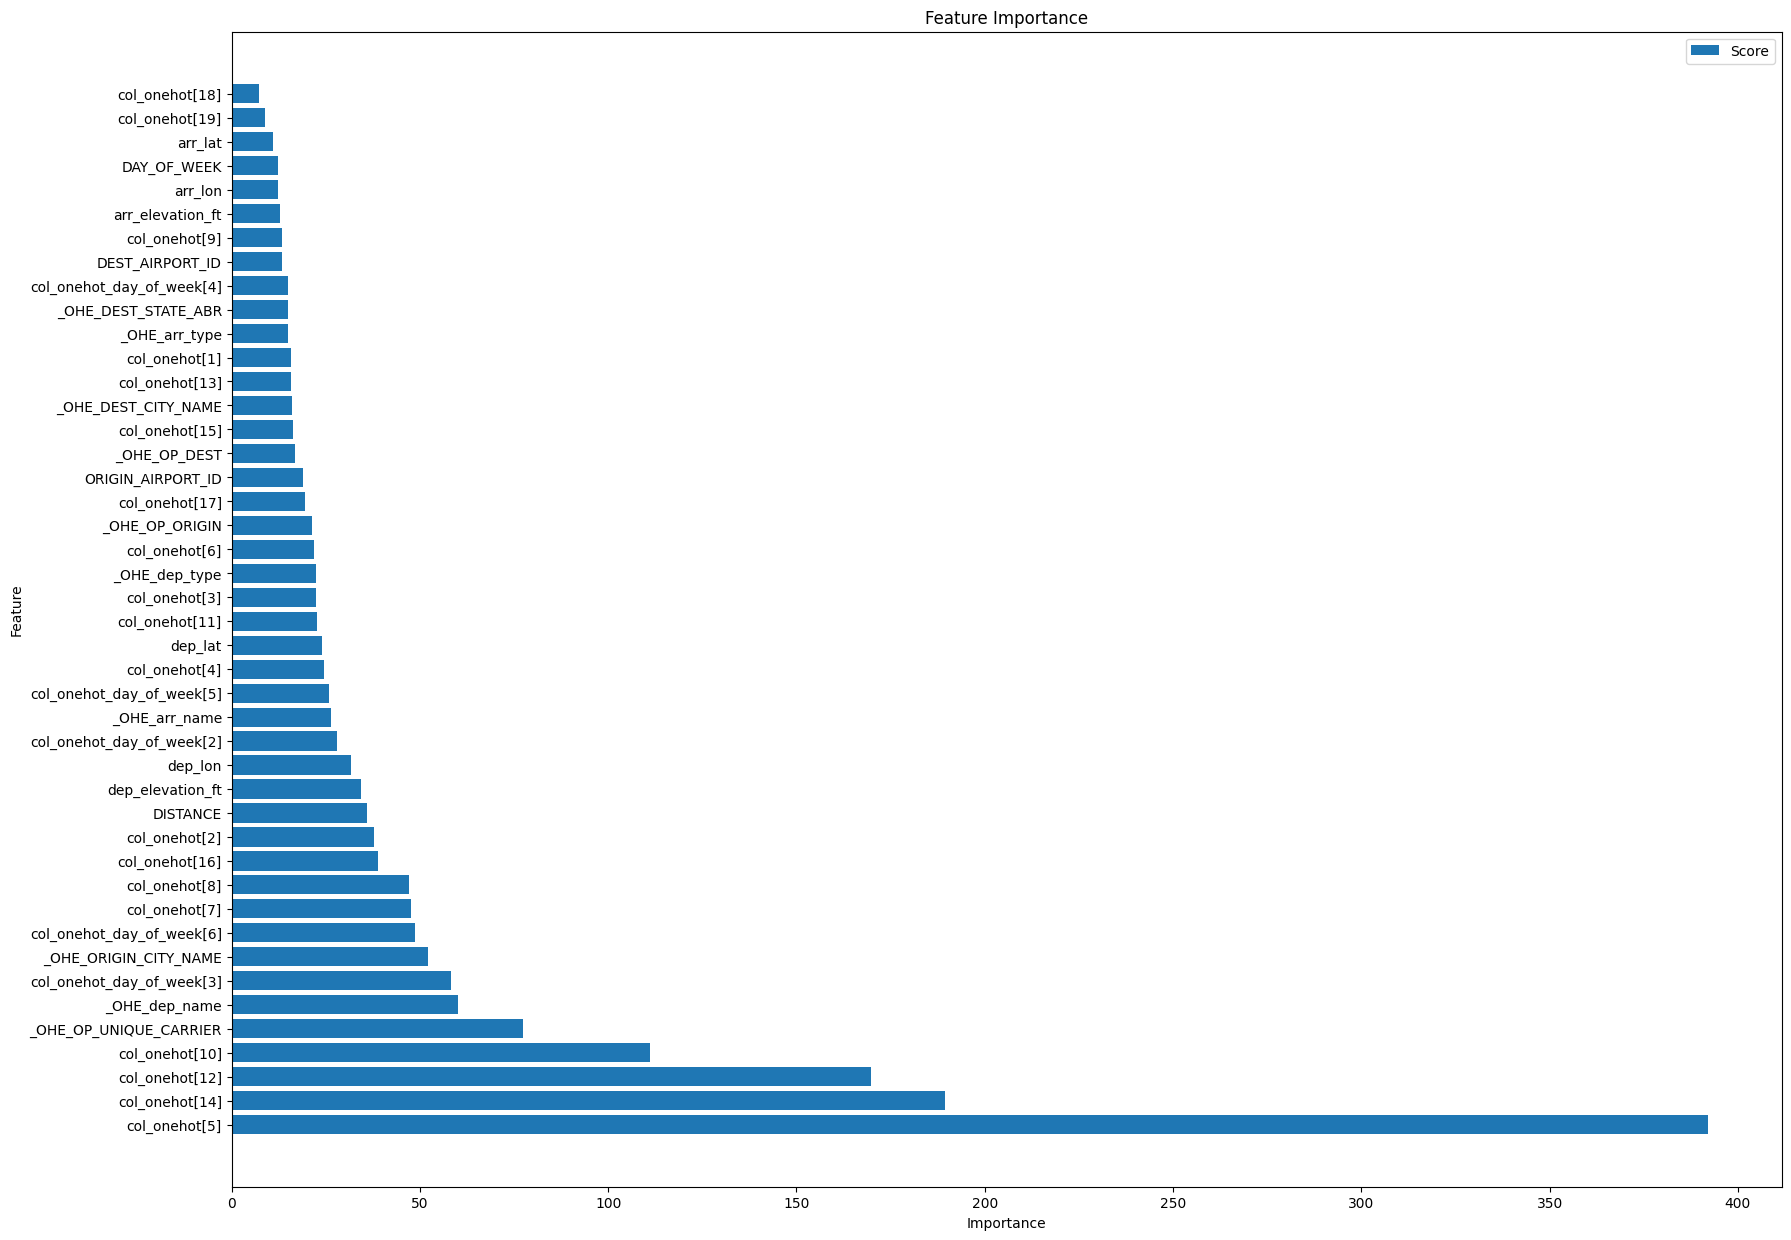

In [145]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
plt.barh(i_f_df.Features, i_f_df.Importance)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.legend(["Score"])
plt.title("Feature Importance")
plt.tight_layout 
plt.show()

## Analysis
##### The feature with the most impact in helping to predict whether or not a flight would be delayed is the airline carrier (represented as col_onehot[n], with n representing a specific airline carrier). Based on the plot, the top four highest features are all related to airline carriers. This is followed by the departure name, meaning certain departing airports are more prone to have delays. This is probably related to how busy and how much traffic that airport typically has. The next feature of highest significance would be col_onehot_day_of_week[3], which represents Wednesday, followed by Saturday.


In [146]:
predictions_df_xgb2_test = xgb_model2.transform(test_data_xgb2)
predictions_df_xgb2_test_columns_renamed = predictions_df_xgb2_test.withColumnRenamed("prediction", "prediction_xgb2_test").withColumnRenamed("dep_delay_int", "dep_delay_int_xgb2_test").withColumnRenamed("rawPrediction", "rawPrediction_xgb2_test").withColumnRenamed("probability", "probability_xgb2_test")
predictions_df_xgb2_test_columns_renamed.select("rawPrediction_xgb2_test", "probability_xgb2_test", "prediction_xgb2_test", "dep_delay_int_xgb2_test").show(100)

+-----------------------+---------------------+--------------------+-----------------------+
|rawPrediction_xgb2_test|probability_xgb2_test|prediction_xgb2_test|dep_delay_int_xgb2_test|
+-----------------------+---------------------+--------------------+-----------------------+
|   [1.33016037940979...| [0.79086714982986...|                 0.0|                      0|
|   [1.33659470081329...| [0.79192936420440...|                 0.0|                      0|
|   [1.33659470081329...| [0.79192936420440...|                 0.0|                      0|
|   [1.22210419178009...| [0.77243363857269...|                 0.0|                      0|
|   [0.44607070088386...| [0.60970461368560...|                 0.0|                      0|
|   [0.71845948696136...| [0.67226767539978...|                 0.0|                      0|
|   [0.89788258075714...| [0.71051418781280...|                 0.0|                      1|
|   [0.85955911874771...| [0.70256853103637...|                 0.0|  

In [147]:
#ok in DataBricks but timed out in Kaggle
#tp_xgb2_test = float(predictions_df_xgb2_test_columns_renamed.filter("prediction_xgb2_test == 1.0 AND dep_delay_int_xgb2_test == 1").count())
#fp_xgb2_test = float(predictions_df_xgb2_test_columns_renamed.filter("prediction_xgb2_test == 1.0 AND dep_delay_int_xgb2_test == 0").count())
#tn_xgb2_test = float(predictions_df_xgb2_test_columns_renamed.filter("prediction_xgb2_test == 0.0 AND dep_delay_int_xgb2_test == 0").count())
#fn_xgb2_test = float(predictions_df_xgb2_test_columns_renamed.filter("prediction_xgb2_test == 0.0 AND dep_delay_int_xgb2_test == 1").count())
#pr_xgb2_test = tp_xgb2_test / (tp_xgb2_test + fp_xgb2_test)
#re_xgb2_test = tp_xgb2_test / (tp_xgb2_test + fn_xgb2_test)
#metrics = spark.createDataFrame([
# ("TP", tp_xgb2_test),
# ("FP", fp_xgb2_test),
# ("TN", tn_xgb2_test),
# ("FN", fn_xgb2_test),
# ("Precision", pr_xgb2_test),
# ("Recall", re_xgb2_test),
# ("myAccuracy", (tp_xgb2_test+tn_xgb2_test)/(tp_xgb2_test+fp_xgb2_test+tn_xgb2_test+fn_xgb2_test)),
# ("F1", 2*pr_xgb2_test*re_xgb2_test/(re_xgb2_test+pr_xgb2_test))],["metric", "value"])
#metrics.show()

In [148]:
evaluator_xgbtest_mc_acc = MulticlassClassificationEvaluator(labelCol="dep_delay_int_xgb2_test", predictionCol="prediction_xgb2_test", metricName="accuracy")
xgbtest_accuracy = evaluator_xgbtest_mc_acc.evaluate(predictions_df_xgb2_test_columns_renamed)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [149]:
evaluator_xgbtest_mc_precision = MulticlassClassificationEvaluator(labelCol="dep_delay_int_xgb2_test", predictionCol="prediction_xgb2_test", metricName="precisionByLabel")
xgbtest_precision = evaluator_xgbtest_mc_precision.evaluate(predictions_df_xgb2_test_columns_renamed)

In [150]:
evaluator_xgbtest_mc_recall = MulticlassClassificationEvaluator(labelCol="dep_delay_int_xgb2_test", predictionCol="prediction_xgb2_test", metricName="recallByLabel")
xgbtest_recall = evaluator_xgbtest_mc_recall.evaluate(predictions_df_xgb2_test_columns_renamed)

In [151]:
evaluator_xgbtest_mc_f1 = MulticlassClassificationEvaluator(labelCol="dep_delay_int_xgb2_test", predictionCol="prediction_xgb2_test", metricName="f1")
xgbtest_f1 = evaluator_xgbtest_mc_f1.evaluate(predictions_df_xgb2_test_columns_renamed)

In [152]:
#area under ROC
evaluator_xgbtest_bc = BinaryClassificationEvaluator(labelCol="dep_delay_int_xgb2_test", rawPredictionCol="prediction_xgb2_test", metricName="areaUnderROC")
xgbtest_areaUnderROC = evaluator_xgbtest_bc.evaluate(predictions_df_xgb2_test_columns_renamed)

## Testing Set: Metrics

In [153]:
print(f"XGBTest Accuracy: {xgbtest_accuracy}")
print(f"XGBTest Precision: {xgbtest_precision}")
print(f"XGBTest Recall: {xgbtest_recall}")
print(f"XGBTest F1: {xgbtest_f1}")
print(f"XGBTest AreaUnderROC: {xgbtest_areaUnderROC}")

XGBTest Accuracy: 0.6606955061641112
XGBTest Precision: 0.6741759002032974
XGBTest Recall: 0.8905753493996231
XGBTest F1: 0.620911867367753
XGBTest AreaUnderROC: 0.5811511629114547


## Analysis on Test Dataset
##### Applying testing dataset into the 2nd set's XGBoost model generated very similar metrics as the training dataset's metrics for the 2nd set's XGBoost model. This shows that the model is consistent in generating similar results.


## Conclusion
##### Using StringIndexer, OneHotEncoders for Day of the Week and also Carriers, followed by MinMaxScaler, and then grouping them into a column of vectors using VectAssembler seems to be the way to go. The dataset used consists of only data related to the flight itself and doesn't include any other types of information such as weather, which would play a role in determining whether a flight would be delayed. However, given what the dataset provided, the model's determination of features that had the most significance seem to make sense. It identified that a certain airline carrier had significant influence on whether or not a flight would be delayed. It also identified Wednesday as the day of the week to play a large role in determining whether or not a flight would be delayed. These are in relation to the other features in the dataset. This suggests that given what the dataset provided, the ML classifier did a relatively good job in creating a classifier model to predict whether or not a flight would be delayed. It would be even better if data such as weather condition was provided. This is further supported by generating similar metrics results when running XGBoost on the testing dataset.
